In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import random
import string

In [177]:
from scipy.sparse import random as sparse_random

In [179]:
from scipy import stats

In [223]:
import scipy.sparse as sps

In [180]:
from sklearn.preprocessing import normalize

In [181]:
import json

In [182]:
from tqdm import tqdm_notebook

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt

# Genesis parsing

In [184]:
cyber_distribution = json.load(open("./data/cyber_distribution.json"))

In [185]:
del cyber_distribution["total"]

In [186]:
cyber_distribution

{'cosmos_drop': '5000000000',
 'cybercongress': '4',
 'ethereum_drop': '10000000000',
 'foundation_auction_multisig': '60',
 'game_of_thrones': '20',
 'inventors': '2',
 'investors': '5',
 'pre_genesis_round': '5',
 'validators_drop': '2700000000000'}

In [235]:
cyber_distribution = {'cosmos_drop': '5000000000',
 'cybercongress': '4000000000',
 'ethereum_drop': '10000000000',
 'foundation_auction_multisig': '60000000000',
 'game_of_thrones': '20000000000',
 'inventors': '2000000000',
 'investors': '5000000000',
 'pre_genesis_round': '5000000000',
 'validators_drop': '27000000000'}

TODO define cosmos and ethereum groups from genesis

In [590]:
synth_genesis = []
group_size = 100

In [591]:
for group, amount in cyber_distribution.items():
    amount = int(amount)
    for i in range(group_size):
        agent_params = {
            'group': group,
            'balance': amount / group_size,
            'address': group + str(i)
        }
        synth_genesis.append(agent_params)

In [592]:
block_chunk = 1

Аккаунт + количество монет + когорта

# Model definitions

1. Balances are changing
2. Dynamic parameters are chaning
3. Bondings are changing
4. Total inflation is changing

In [851]:
def random_string(string_length=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

146 default validators

Proposals!?

In [852]:
class FastUtils:    
    # TODO remove duplicates from Agent class
    max_comission_rate = 0.1
    claim_probability = 0.01
    transaction_probability = 0.00001
    
    max_transaction_rate = 1
    
    def __init__(self, network):
        self.network = network
        if len(self.network.agents):
            self.density = self.transaction_probability / len(network.agents) * self.network.blocks_per_iteration
    
    def _create_balances(self):
        return np.array([agent.balance for agent in self.network.agents])
    
    def _set_balances(self, balances):
        for index, agent in enumerate(self.network.agents):
            agent.balance = balances[index]
            
    def _set_total_comission(self, comission):
        self.network.transactions_reward = comission
    
    def create_similar_random_matrix(self, coo_matrix):
        rows = coo_matrix.tocoo().row
        cols = coo_matrix.tocoo().col
        data = np.random.rand(len(rows))
        return sps.coo_matrix((data, (rows, cols)), shape=coo_matrix.shape)
    
    def do_random_transactions(self):
        assert self.density > 0, "Transactions density is insignificant"
        balances = self._create_balances()
        agents_size = balances.shape[0]
        
        random_max_transaction_rates = self.max_transaction_rate * np.random.rand(balances.shape[0])
        random_total_transaction_rates = sparse_random(agents_size, agents_size, density=self.density)
        normalized_random_total_transaction_rates = normalize(random_total_transaction_rates, norm='l1', axis=1)
        total_transaction_amounts = normalized_random_total_transaction_rates.T.multiply(random_max_transaction_rates * balances).T

        transactions_sended = (total_transaction_amounts > 0)
        random_comission_rates = self.max_comission_rate * self.create_similar_random_matrix(transactions_sended)
        comission_amounts = total_transaction_amounts.multiply(random_comission_rates)
        transaction_amounts = total_transaction_amounts - comission_amounts

        income = transaction_amounts.sum(axis=0).A1
        outcome = transaction_amounts.sum(axis=1).A1 + comission_amounts.sum(axis=1).A1
        new_balances = balances + income - outcome
        total_comission = comission_amounts.sum()
        
        self._set_balances(balances)
        self._set_total_comission(total_comission)

In [853]:
class Network():
    # Constants
    blocks_per_year = 1/3 * 60 * 60 * 24 * 365 
    max_inflation = 0.12
    min_inflation = 0.5
    inflation_rate = 0.1
    start_inflation = 0.6
    bonding_goal = 0.9
    blocks_per_iteration = 1/3 * 60 * 60 * 24 * 30
    new_agents_per_iteration = 0.001
    
    # Class fields
    block = -1
    transactions_reward = 0 # Multiple transactions
    inflation = start_inflation
    total_bonding = 0
    total_balance = 0
    stats = None
    
    @classmethod
    def from_json(self, description, validators=100):
        network = Network(validators, len(description))
        network.agents = []
        for agent_description in description:
            agent = Agent.from_json(network, agent_description)
            network.agents.append(agent)
            # TODO add default agent for this
            network.total_balance += agent.genesis_part
        return network
    
    def _create_validators(self):
        self.validators = []
        # TODO increase validators per year
        for i in range(self.validators_amount):
            validator = Validator(self)
            self.validators.append(validator)
    
    def _create_agents(self):
        self.agents = []
        for i in range(self.agents_amount):
            agent = Agent(self)
            self.agents.append(agent)
            
    def _initialize_fast_utils(self):
        self.fast_utils = FastUtils(self)
    
    def __init__(self, validators_amount, agents_amount):
        self.validators_amount = validators_amount
        self.agents_amount = agents_amount
        self._create_validators()
        self._create_agents()
        self._initialize_fast_utils()
        
    def _change_inflation(self):
        if (self.block == 0) or ((self.block // self.blocks_per_iteration) % (self.blocks_per_year // self.blocks_per_iteration) != 0):
            return
        
        print("Inflation changes!")
        
        current_bonding_rate = self.total_bonding / self.total_balance
        
        print(current_bonding_rate)

        if (self.bonding_goal < current_bonding_rate):
            self.inflation -= self.inflation_rate
        else:
            self.inflation += self.inflation_rate
        self.inflation = max(self.min_inflation, min(self.max_inflation, self.inflation))
    
    def _increase_block(self):
        self.block += self.blocks_per_iteration
        self._change_inflation()
        self.transactions_reward = 0
        self.block_reward = self.inflation * self.total_balance / self.blocks_per_year * self.blocks_per_iteration
        
    def _act_validators(self):
        self.total_balance += self.block_reward
        for validator in tqdm_notebook(self.validators):
            validator.act()
    
    def _add_new_agents(self):
        new_agens_amount = int(self.agents_amount * self.new_agents_per_iteration)
        self.agents_amount += new_agens_amount
        for i in range(new_agens_amount):
            agent = Agent(self)
            agent.group = "new_agents"
            agent.genesis_part = 0
            agent.balance = 0
            self.agents.append(agent)
            
    def _act_agents(self):
        for agent in tqdm_notebook(self.agents):
            agent.act()
        self.fast_utils.do_random_transactions()
        self._add_new_agents()
            
    def _update_stats(self):
        self.stats = {}
        for agent in self.agents:
            self.stats[agent.group] = self.stats.get(agent.group, 0) + agent.balance
        for agent in self.agents:
            self.stats["unclaimed_" + agent.group] = self.stats.get("unclaimed_" + agent.group, 0) + agent.genesis_part
        self.stats["inflation"] = self.inflation
        self.stats["total_balance"] = self.total_balance
        self.stats["total_bonding"] = self.total_bonding
            
    def act(self):
        self._increase_block()
        self._act_agents()
        self._act_validators()
        self._update_stats()
    
    # TODO These methods should be moved to proper locations

    def get_random_agent(self):
        return np.random.choice(self.agents)
    
    def get_random_validator(self):
        return np.random.choice(self.validators)
    
    def send_transaction(self, sender, receiver, amount, comission):
        assert sender.balance >= amount + comission
        sender.balance -= amount + comission
        receiver.balance += amount
        self.transactions_reward += comission
        
    def bond_validator(self, agent, validator, new_stake):
        old_stake = validator.bonding.get(agent, 0)
        difference = new_stake - old_stake
        assert agent.balance >= difference
        agent.balance -= difference
        validator.bonding[agent] = new_stake
        validator.total_bonding += difference
        self.total_bonding += difference
        
    def get_voting_power(self, validator):
        # TODO add cache for voting power
        return validator.total_bonding / (self.total_bonding + 0.00000001)
    
    def claim_tokens(self, agent, amount):
        assert agent.genesis_part >= amount
        agent.balance += amount
        agent.genesis_part -= amount
        
    def send_reward(self, validator, agent, rate):
        agent.balance += validator.reward * rate

In [854]:
class NetworkParticipant():
    network = None
    id = None
    
    def __init__(self, network):
        self.network = network
        self.id = random_string()

Agent:
- Genesis state
- Balance (total, bonded)
- Transaction probability
- Bonded validators
- Sended transactions

Each block for agent
1. Claim the rest of tokens
2. Do random transactions 
3. Get reward from validators 
4. Rebond tokens

For the cohort of agents:
1. Increase total amount of a cohort
2. Save cohort amount for a block
3. Use genesis file to define group size

In [855]:
class Agent(NetworkParticipant):
    group = None
    
    # Constants
    # Define constants with high influence on results
    max_comission_rate = 0.1
    claim_probability = 0.01
    transaction_probability = 0.9
    rebond_probability = 0.1
    
    # Dynamic parameters
    genesis_part = 0
    balance = 0
    
    @classmethod
    def from_json(cls, network, description):
        agent = Agent(network)
        agent.genesis_part = description['balance']
        agent.group = description['group']
        agent.id = description['address']
        return agent
    
    def __init__(self, network, genesis_part=100):
        super().__init__(network)
        self.genesis_part = genesis_part
        
    def _claim(self):
        # TODO claim comission
        # Periodically
        if np.random.rand() > self.claim_probability:
            return
        
        amount = np.random.rand() * self.genesis_part
        self.network.claim_tokens(self, amount)
    
    def _do_random_transaction(self):
        if np.random.rand() > self.transaction_probability:
            return
        
        receiver = self
        while receiver == self:
            receiver = self.network.get_random_agent()
        total_amount = np.random.rand() * self.balance
        comission = np.random.rand() * self.max_comission_rate * total_amount
        amount = total_amount - comission
        self.network.send_transaction(self, receiver, amount, comission)
     
    # rename to "delegate"
    def _rebond_tokens(self):
        if np.random.rand() > self.rebond_probability:
            return
        
        validator = self.network.get_random_validator()
        amount = np.random.rand() * self.balance
        self.network.bond_validator(self, validator, amount)
    
    def act(self):
        self._claim()
        # TODO no need in this method for now
#         self._do_random_transaction()
        self._rebond_tokens()

Validator:
- Comission
- Voting power
- Slowness probability
- Double-spend probability

Each block for validator:
1. Create
2. Update comission
3. Gather all transactions reward
4. Receive block reward depending on voting power
5. Do random event (nothing, double-spend, slowness)

Validator = agent

In [856]:
class Validator(NetworkParticipant):
    # Dynamic parameters
    comission_rate = 0
    total_bonding = 0
    reward = 0
    
    def __init__(self, network):
        super().__init__(network)
        self.bonding = {}
    
    def _update_comission(self):
        self.comission_rate = np.random.rand()
        
    def _receive_reward(self):
        voting_power = self.network.get_voting_power(self)
        self.reward = voting_power * (self.network.block_reward + self.network.transactions_reward)
        # TODO move part of reward to validator's owner
        self.reward = (1 - self.comission_rate) * self.reward
        
    def _broadcast_reward(self):
        for agent, stake in self.bonding.items():
            rate = stake / (self.total_bonding + 0.000001)
            self.network.send_reward(self, agent, rate)
            
    def act(self):
        self._update_comission()
        self._receive_reward()
        self._broadcast_reward()

# Tests

In [857]:
def assert_catch_exception(test_function, exception_class):
    exception_caught = False
    try:
        test_function()
    except exception_class:
        exception_caught = True
    assert exception_caught

## Network

Network should be created from json

In [858]:
network = Network.from_json([{
    "address": "0x1",
    "balance": 1,
    "group": "test"
}], 5)

assert len(network.agents) == 1
assert network.agents[0].network == network
assert len(network.validators) == 5
assert network.total_balance == 1

Network should create validators and agents when created

In [859]:
network = Network(1, 1)

assert len(network.validators) == 1
assert len(network.agents) == 1

Network should send transactions

In [860]:
network = Network(1, 1)

sender = Agent(network)
sender.balance = 100

receiver = Agent(network)
receiver.balance = 10

network.send_transaction(sender, receiver, 10, 10)
assert sender.balance == 100 - 20
assert receiver.balance == 10 + 10
assert network.transactions_reward == 10

network.send_transaction(sender, receiver, 80, 0)
assert_catch_exception(
    lambda: network.send_transaction(sender, receiver, 80, 10),
    AssertionError
)

Network should bond agent stake to validators

In [861]:
network = Network(1, 1)

validator = Validator(network)
assert not validator.bonding

agent = Agent(network)
agent.balance = 100

network.bond_validator(agent, validator, 20)
assert validator.bonding[agent] == 20
assert agent.balance == 100 - 20
assert validator.total_bonding == 20
assert network.total_bonding == 20

network.bond_validator(agent, validator, 10)
assert validator.bonding[agent] == 10
assert agent.balance == 100 - 10
assert validator.total_bonding == 10
assert network.total_bonding == 10

network.bond_validator(agent, validator, 100)
assert_catch_exception(
    lambda: network.bond_validator(agent, validator, 110),
    AssertionError
)

Network should return voting power for each validator

In [862]:
network = Network(1, 1)

validator1 = Validator(network)
validator2 = Validator(network)

agent1 = Agent(network)
agent1.balance = 100

agent2 = Agent(network)
agent2.balance = 100

agent3 = Agent(network)
agent3.balance = 100

network.bond_validator(agent1, validator1, 10)
network.bond_validator(agent2, validator1, 10)
network.bond_validator(agent3, validator2, 10)

# print(network.get_voting_power(validator1))
assert np.abs(network.get_voting_power(validator1) - 20 / 30) < 0.001
assert np.abs(network.get_voting_power(validator2) - 10 / 30) < 0.001

Network should send reward from validator to agent

In [863]:
network = Network(1, 1)

validator = Validator(network)
validator.reward = 200

agent = Agent(network)
agent.balance = 10

network.send_reward(validator, agent, 0.1)

assert agent.balance == 10 + 0.1 * 200

Network should increase block

In [864]:
network = Network(1, 1)
network.blocks_per_iteration = 1

network._increase_block()
assert network.block == 0

network._increase_block()
assert network.block == 1

Network should reset transactions reward after increase

In [865]:
network = Network(1, 1)
network.blocks_per_iteration = 1
network.transactions_reward = None

network._increase_block()
assert network.transactions_reward == 0

Network should recount block reward after increase

In [866]:
network = Network(1, 1)
network.inflation = 0.1
network.blocks_per_year = 2
network.total_balance = 100
network.block_reward = None
network.blocks_per_iteration = 1

network._increase_block()
assert network.block_reward == 0.1 * 100 / 2

Network should recount inflation each year depending on total bonding and total balance

In [867]:
network = Network(1, 1)
network.blocks_per_iteration = 1
network.start_inflation = 0.1
network.max_inflation = 0.2
network.min_inflation = 0.0
network.inflation_rate = 0.1
network.blocks_per_year = 2
network.bonding_goal = 0.9

network.total_bonding = 0
network.total_balance = 100

# Initial inflation is equal to start one
network._increase_block()
assert network.inflation == 0.1

# Do not change inflation during a year
network._increase_block()
assert network.inflation == 0.1

# Increase inflation by defined rate when bonding rate is too low
network._increase_block()
assert network.inflation == 0.1 + 0.1

# Do not change inflation more than max
network._increase_block()
network._increase_block()
assert network.inflation == 0.2

network.total_bonding = 55
network.total_balance = 100

# Decrease inflation by defined rate when bonding rate is too low
network._increase_block()
network._increase_block()
network._increase_block()
network._increase_block()
assert network.inflation == 0.2 - 0.1 - 0.1

# Do not change inflation less than min
network._increase_block()
network._increase_block()
assert network.inflation == 0.0

AssertionError: 

Network should return random agent

In [868]:
network = Network(1, 2)
assert network.get_random_agent() in network.agents

Network should return random validator

In [869]:
network = Network(2, 1)
assert network.get_random_validator() in network.validators

Network should claim agent tokens

In [870]:
network = Network(1, 1)
agent = Agent(network)
agent.genesis_part = 10

network.claim_tokens(agent, 5)
assert agent.genesis_part == 5
assert agent.balance == 5

assert_catch_exception(
    lambda: network.claim_tokens(agent, 6),
    AssertionError
)

Network should count statistics by groups after each iteration

In [871]:
network = Network(1, 1)
agent = network.agents[0]
agent.balance = 10
agent.group = "test"

network._update_stats()
assert network.stats["test"] == 10

## Agent

Agent should send nonzero random transaction to another agent

In [872]:
# Deprecated: this method has an accelerated implementation

network = Network(1, 2)
agent = network.agents[0]

agent.transaction_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._do_random_transaction()
    
assert agent.balance < 100
assert network.agents[1].balance > 0

Agent should rebond tokens randomly

In [873]:
network = Network(1, 1)
agent = network.agents[0]
validator = network.validators[0]

agent.rebond_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._rebond_tokens()
    
assert agent.balance < 100
assert validator.bonding[agent] > 0

Agent should claim tokens

In [874]:
network = Network(1, 1)
agent = network.agents[0]
assert agent.balance == 0

agent.claim_probability = 1
agent.genesis_part = 100

agent._claim()
    
assert agent.balance > 0
assert agent.genesis_part < 100

Agent should create itself from json description

In [875]:
network = Network(0, 0)
agent = Agent.from_json(network, {
    'address': "0x1",
    'group': "test",
    "balance": 110
})
assert agent.genesis_part == 110
assert agent.group == "test"
assert agent.id == "0x1"
assert agent.network == network

## Validator

Validator should update comission

In [876]:
network = Network(1, 1)
validator = network.validators[0]

old_comission_rate = validator.comission_rate

validator._update_comission()
assert validator.comission_rate != old_comission_rate

Validator should receive reward

In [877]:
network = Network(1, 1)
validator = network.validators[0]
network.get_voting_power = lambda x: 0.1
network.block_reward = 100
network.transactions_reward = 200
validator.comission_rate = 0.1

validator._receive_reward()
assert round(validator.reward) == round((1 - 0.1) * 0.1 * (100 + 200))

Validator should send reward to all bonded agents depending on their rates

In [878]:
network = Network(1, 2)
validator = network.validators[0]
agent1 = network.agents[0]
agent2 = network.agents[1]

agent1.balance = 100
agent2.balance = 100

network.bond_validator(agent1, validator, 1)
network.bond_validator(agent2, validator, 4)

validator.reward = 20

validator._broadcast_reward()
assert np.abs(agent1.balance - ((100 - 1) + 20 * 1 / 5)) < 0.0001
assert np.abs(agent2.balance - ((100 - 4) + 20 * 4 / 5)) < 0.0001

# Big network evaluation

In [879]:
network = Network.from_json(synth_genesis, 100)

In [880]:
all_stats = []
for i in tqdm_notebook(range(100)):
    network.act()
    print(network.stats)
    all_stats.append(network.stats.copy())

Inflation changes!
0.0


{'unclaimed_game_of_thrones': 19841664065.067356, 'inflation': 0.5, 'validators_drop': 107347339.56076555, 'unclaimed_foundation_auction_multisig': 60000000000.0, 'unclaimed_ethereum_drop': 9877703035.660177, 'cybercongress': 9536582.124163244, 'cosmos_drop': 804071.4207936839, 'total_bonding': 0.0, 'investors': 47372113.296089105, 'unclaimed_validators_drop': 26892652660.439236, 'unclaimed_investors': 4952627886.703911, 'foundation_auction_multisig': 0.0, 'pre_genesis_round': 24771075.05165776, 'inventors': 13011491.68646112, 'total_balance': 143671232876.71234, 'unclaimed_inventors': 1986988508.3135388, 'ethereum_drop': 122296964.33982304, 'unclaimed_pre_genesis_round': 4975228924.948342, 'game_of_thrones': 158335934.93264472, 'unclaimed_cybercongress': 3990463417.875837, 'unclaimed_cosmos_drop': 4999195928.579206}


{'unclaimed_game_of_thrones': 19642543532.423172, 'inflation': 0.5, 'validators_drop': 107347339.56076555, 'unclaimed_foundation_auction_multisig': 59985866226.92962, 'unclaimed_ethereum_drop': 9713075415.536661, 'cybercongress': 1540696852.9350955, 'cosmos_drop': 804071.4207936839, 'total_bonding': 5893600.684188176, 'investors': 1990400744.687066, 'unclaimed_validators_drop': 26892652660.439236, 'unclaimed_investors': 4935225477.909429, 'foundation_auction_multisig': 14133773.07038417, 'pre_genesis_round': 24771075.05165776, 'inventors': 52705671.63726244, 'total_balance': 149575530118.22107, 'unclaimed_inventors': 1947294328.3627374, 'ethereum_drop': 286924584.4633381, 'unclaimed_pre_genesis_round': 4975228924.948342, 'game_of_thrones': 357456467.576828, 'unclaimed_cybercongress': 3941322372.165241, 'unclaimed_cosmos_drop': 4999195928.579206}


{'unclaimed_game_of_thrones': 19583409737.329193, 'inflation': 0.5, 'validators_drop': 107347339.56076555, 'unclaimed_foundation_auction_multisig': 59985866226.92962, 'unclaimed_ethereum_drop': 9624173822.523228, 'cybercongress': 1607700139.0282266, 'cosmos_drop': 804071.4207936839, 'total_bonding': 43189553.188328475, 'investors': 2193234080.402989, 'unclaimed_validators_drop': 26892652660.439236, 'unclaimed_investors': 4935225477.909429, 'foundation_auction_multisig': 14133773.07038417, 'pre_genesis_round': 60062134.809542745, 'inventors': 52705671.63726244, 'total_balance': 155722469712.12057, 'unclaimed_inventors': 1947294328.3627374, 'ethereum_drop': 405867139.4863548, 'unclaimed_pre_genesis_round': 4939937865.190457, 'game_of_thrones': 416590262.6708078, 'unclaimed_cybercongress': 3941322372.165241, 'unclaimed_cosmos_drop': 4999195928.579206}


{'unclaimed_game_of_thrones': 19492501054.999084, 'inflation': 0.5, 'validators_drop': 248869316.60021794, 'unclaimed_foundation_auction_multisig': 59324884353.9984, 'unclaimed_ethereum_drop': 9570135048.15694, 'cybercongress': 1973279562.5618904, 'cosmos_drop': 804071.4207936839, 'total_bonding': 204258079.61675215, 'investors': 2247219403.0549207, 'unclaimed_validators_drop': 26751130683.399784, 'unclaimed_investors': 4893313785.479977, 'foundation_auction_multisig': 871126270.226178, 'pre_genesis_round': 484260991.0337949, 'inventors': 52705671.63726244, 'total_balance': 162122023261.93375, 'unclaimed_inventors': 1947294328.3627374, 'ethereum_drop': 710481453.919241, 'unclaimed_pre_genesis_round': 4900769949.059536, 'game_of_thrones': 507498945.00091636, 'unclaimed_cybercongress': 3889813817.735701, 'unclaimed_cosmos_drop': 4999195928.579206}


{'unclaimed_game_of_thrones': 19324411278.287357, 'inflation': 0.5, 'validators_drop': 453613130.3884176, 'unclaimed_foundation_auction_multisig': 58540240714.28857, 'unclaimed_ethereum_drop': 9570135048.15694, 'cybercongress': 3893395654.6255, 'cosmos_drop': 48757476.6221398, 'total_bonding': 329347006.76136374, 'investors': 2267047657.421858, 'unclaimed_validators_drop': 26546386869.611584, 'unclaimed_investors': 4893313785.479977, 'foundation_auction_multisig': 1750709800.65565, 'pre_genesis_round': 827456133.4790137, 'inventors': 130521074.73580514, 'total_balance': 168784572163.1091, 'unclaimed_inventors': 1933944828.80519, 'ethereum_drop': 1966958565.0194964, 'unclaimed_pre_genesis_round': 4900769949.059536, 'game_of_thrones': 675588721.7126424, 'unclaimed_cybercongress': 3874344485.170782, 'unclaimed_cosmos_drop': 4951242523.37786}


{'unclaimed_game_of_thrones': 19324411278.287357, 'inflation': 0.5, 'validators_drop': 449332222.11711013, 'unclaimed_foundation_auction_multisig': 58540240714.28857, 'unclaimed_ethereum_drop': 9570135048.15694, 'cybercongress': 4203218774.420554, 'cosmos_drop': 48767268.19475743, 'total_bonding': 1752863219.4221141, 'investors': 2275108740.967644, 'unclaimed_validators_drop': 26546386869.611584, 'unclaimed_investors': 4888497791.812089, 'foundation_auction_multisig': 2253282848.991668, 'pre_genesis_round': 945140335.2654564, 'inventors': 133086954.8355893, 'total_balance': 175720924443.78482, 'unclaimed_inventors': 1933944828.80519, 'ethereum_drop': 1858695577.8864803, 'unclaimed_pre_genesis_round': 4861072068.098157, 'game_of_thrones': 675588721.7126424, 'unclaimed_cybercongress': 3874344485.170782, 'unclaimed_cosmos_drop': 4951242523.37786}


{'unclaimed_game_of_thrones': 19194741065.552567, 'inflation': 0.5, 'validators_drop': 527731818.27294177, 'unclaimed_foundation_auction_multisig': 58249753836.103966, 'unclaimed_ethereum_drop': 9506232229.749308, 'cybercongress': 4557498776.556633, 'cosmos_drop': 49142026.33526811, 'total_bonding': 1783562022.2893693, 'investors': 2282790987.8368726, 'unclaimed_validators_drop': 26546386869.611584, 'unclaimed_investors': 4888497791.812089, 'foundation_auction_multisig': 2827889233.421552, 'pre_genesis_round': 1873137035.7016015, 'inventors': 168217904.74714434, 'total_balance': 182942332297.63898, 'unclaimed_inventors': 1908217489.7576396, 'ethereum_drop': 2970145703.062417, 'unclaimed_pre_genesis_round': 4861072068.098157, 'game_of_thrones': 805258934.4474356, 'unclaimed_cybercongress': 3874344485.170782, 'unclaimed_cosmos_drop': 4951242523.37786}


{'unclaimed_game_of_thrones': 19194741065.552567, 'inflation': 0.5, 'validators_drop': 620820319.417237, 'unclaimed_foundation_auction_multisig': 58249753836.103966, 'unclaimed_ethereum_drop': 9463686016.747248, 'cybercongress': 4989326682.422297, 'cosmos_drop': 49219065.99158944, 'total_bonding': 1872364771.696271, 'investors': 2319118411.691247, 'unclaimed_validators_drop': 26546386869.611584, 'unclaimed_investors': 4867450751.478827, 'foundation_auction_multisig': 3380960355.9236736, 'pre_genesis_round': 2621583084.748164, 'inventors': 288862503.2301566, 'total_balance': 190460510337.26797, 'unclaimed_inventors': 1908217489.7576396, 'ethereum_drop': 4444755453.906055, 'unclaimed_pre_genesis_round': 4856300748.831429, 'game_of_thrones': 805258934.4474356, 'unclaimed_cybercongress': 3874344485.170782, 'unclaimed_cosmos_drop': 4951242523.37786}


{'unclaimed_game_of_thrones': 19038441754.497055, 'inflation': 0.5, 'validators_drop': 440660200.45550334, 'unclaimed_foundation_auction_multisig': 57533582178.30643, 'unclaimed_ethereum_drop': 9436450784.171663, 'cybercongress': 5197934129.623355, 'cosmos_drop': 90414210.86401442, 'total_bonding': 2944695627.1606784, 'investors': 2393203112.7992196, 'unclaimed_validators_drop': 26546386869.611584, 'unclaimed_investors': 4801954613.497878, 'foundation_auction_multisig': 5011004503.923401, 'pre_genesis_round': 3337406405.121788, 'inventors': 454139786.83721167, 'total_balance': 198287654597.70364, 'unclaimed_inventors': 1879553892.6468177, 'ethereum_drop': 6377051527.398908, 'unclaimed_pre_genesis_round': 4826949965.255566, 'game_of_thrones': 961558245.5029413, 'unclaimed_cybercongress': 3855015362.6099215, 'unclaimed_cosmos_drop': 4910135605.131771}


{'unclaimed_game_of_thrones': 19032897141.961746, 'inflation': 0.5, 'validators_drop': 1337372621.501135, 'unclaimed_foundation_auction_multisig': 57533582178.30643, 'unclaimed_ethereum_drop': 9362131284.121656, 'cybercongress': 5585638240.862281, 'cosmos_drop': 107230389.16536132, 'total_bonding': 3804402773.6738176, 'investors': 2452772505.713508, 'unclaimed_validators_drop': 26146464467.65213, 'unclaimed_investors': 4748815359.004077, 'foundation_auction_multisig': 5547854718.955242, 'pre_genesis_round': 3522169642.723728, 'inventors': 572722896.4668401, 'total_balance': 206436462320.89694, 'unclaimed_inventors': 1879553892.6468177, 'ethereum_drop': 8211627831.47642, 'unclaimed_pre_genesis_round': 4777798297.00726, 'game_of_thrones': 967102858.0382552, 'unclaimed_cybercongress': 3855015362.6099215, 'unclaimed_cosmos_drop': 4893328036.507971}


{'unclaimed_game_of_thrones': 18880742252.917007, 'inflation': 0.5, 'validators_drop': 1448584378.0245533, 'unclaimed_foundation_auction_multisig': 57233678984.19467, 'unclaimed_ethereum_drop': 9203972939.03801, 'cybercongress': 6031624174.688417, 'cosmos_drop': 149546040.72399008, 'total_bonding': 4269562390.9499946, 'investors': 2473848759.35781, 'unclaimed_validators_drop': 26146464467.65213, 'unclaimed_investors': 4735223091.09381, 'foundation_auction_multisig': 6016426666.67576, 'pre_genesis_round': 3624125144.2644153, 'inventors': 665285687.9649822, 'total_balance': 214920152553.26257, 'unclaimed_inventors': 1876985456.7467384, 'ethereum_drop': 10712050189.726566, 'unclaimed_pre_genesis_round': 4771267830.256619, 'game_of_thrones': 1097285251.0594842, 'unclaimed_cybercongress': 3855015362.6099215, 'unclaimed_cosmos_drop': 4851104781.896036}


{'unclaimed_game_of_thrones': 18786505484.166603, 'inflation': 0.5, 'validators_drop': 1269529574.284465, 'unclaimed_foundation_auction_multisig': 57233678984.19467, 'unclaimed_ethereum_drop': 9203972939.03801, 'cybercongress': 6575192589.749785, 'cosmos_drop': 149581598.76998287, 'total_bonding': 8003248242.361451, 'investors': 2473626966.6266184, 'unclaimed_validators_drop': 26146464467.65213, 'unclaimed_investors': 4719915210.4177265, 'foundation_auction_multisig': 6421668228.389851, 'pre_genesis_round': 3681264161.921378, 'inventors': 673709606.5900677, 'total_balance': 223752487589.69803, 'unclaimed_inventors': 1860090724.2813597, 'ethereum_drop': 10932574940.490885, 'unclaimed_pre_genesis_round': 4754658413.50693, 'game_of_thrones': 1213255547.0860212, 'unclaimed_cybercongress': 3855015362.6099215, 'unclaimed_cosmos_drop': 4851104781.896036}
Inflation changes!
0.03576830956640473


{'unclaimed_game_of_thrones': 18750902307.95656, 'inflation': 0.5, 'validators_drop': 1796987540.6589098, 'unclaimed_foundation_auction_multisig': 56628657299.88656, 'unclaimed_ethereum_drop': 9070346241.742792, 'cybercongress': 7332671385.375216, 'cosmos_drop': 175437155.10862145, 'total_bonding': 8411979886.355614, 'investors': 3485167069.763367, 'unclaimed_validators_drop': 25879446022.85693, 'unclaimed_investors': 4683844301.284309, 'foundation_auction_multisig': 7274243175.587936, 'pre_genesis_round': 3887581941.410172, 'inventors': 744472502.6611054, 'total_balance': 232947795298.8637, 'unclaimed_inventors': 1844618231.0853896, 'ethereum_drop': 11813522047.097113, 'unclaimed_pre_genesis_round': 4754658413.50693, 'game_of_thrones': 1257551989.8813214, 'unclaimed_cybercongress': 3855015362.6099215, 'unclaimed_cosmos_drop': 4820530386.649797}


{'unclaimed_game_of_thrones': 18750902307.95656, 'inflation': 0.5, 'validators_drop': 2296060846.6761255, 'unclaimed_foundation_auction_multisig': 56551675920.61297, 'unclaimed_ethereum_drop': 9024627581.301952, 'cybercongress': 3786300583.1583657, 'cosmos_drop': 212040507.19921082, 'total_bonding': 12914430188.654184, 'investors': 3957404940.9598603, 'unclaimed_validators_drop': 25735875044.961636, 'unclaimed_investors': 4683844301.284309, 'foundation_auction_multisig': 7721441780.650997, 'pre_genesis_round': 4069326084.008761, 'inventors': 767000880.9025872, 'total_balance': 242520992365.9403, 'unclaimed_inventors': 1844618231.0853896, 'ethereum_drop': 13012845264.018602, 'unclaimed_pre_genesis_round': 4754658413.50693, 'game_of_thrones': 1279017451.368401, 'unclaimed_cybercongress': 3832860648.5981603, 'unclaimed_cosmos_drop': 4784306153.814153}


{'unclaimed_game_of_thrones': 18750902307.95656, 'inflation': 0.5, 'validators_drop': 2712880505.093266, 'unclaimed_foundation_auction_multisig': 56376227621.71687, 'unclaimed_ethereum_drop': 8921613251.396166, 'cybercongress': 3941271037.0884194, 'cosmos_drop': 236130384.22770882, 'total_bonding': 14706029036.60937, 'investors': 4327636204.658348, 'unclaimed_validators_drop': 25735875044.961636, 'unclaimed_investors': 4672572918.680037, 'foundation_auction_multisig': 7702873281.746322, 'pre_genesis_round': 4307508247.574693, 'inventors': 811862152.04531, 'total_balance': 252487608490.568, 'unclaimed_inventors': 1821092266.8069465, 'ethereum_drop': 13979341325.142286, 'unclaimed_pre_genesis_round': 4681077659.856328, 'game_of_thrones': 1197352408.068718, 'unclaimed_cybercongress': 3832860648.5981603, 'unclaimed_cosmos_drop': 4740320783.135156}


{'unclaimed_game_of_thrones': 18750902307.95656, 'inflation': 0.5, 'validators_drop': 2774732680.455791, 'unclaimed_foundation_auction_multisig': 56376227621.71687, 'unclaimed_ethereum_drop': 8921613251.396166, 'cybercongress': 5792492130.862703, 'cosmos_drop': 281701335.98423463, 'total_bonding': 16963677432.020597, 'investors': 4591582379.879503, 'unclaimed_validators_drop': 25735875044.961636, 'unclaimed_investors': 4637485032.625783, 'foundation_auction_multisig': 7934466493.526182, 'pre_genesis_round': 4314404660.778166, 'inventors': 913843906.0354099, 'total_balance': 262863811579.22147, 'unclaimed_inventors': 1790926665.1525328, 'ethereum_drop': 14650062053.361067, 'unclaimed_pre_genesis_round': 4681077659.856328, 'game_of_thrones': 1205470298.3946517, 'unclaimed_cybercongress': 3832860648.5981603, 'unclaimed_cosmos_drop': 4716723001.913015}


{'unclaimed_game_of_thrones': 18720977115.52309, 'inflation': 0.5, 'validators_drop': 3122095570.210707, 'unclaimed_foundation_auction_multisig': 56111812381.76547, 'unclaimed_ethereum_drop': 8919209097.473541, 'cybercongress': 8741783899.110748, 'cosmos_drop': 376410477.95851034, 'total_bonding': 17204618153.228218, 'investors': 4850385505.350925, 'unclaimed_validators_drop': 25719130295.13468, 'unclaimed_investors': 4635938185.199299, 'foundation_auction_multisig': 8903069977.27712, 'pre_genesis_round': 4536434968.700022, 'inventors': 967446466.7757103, 'total_balance': 273666433972.8881, 'unclaimed_inventors': 1790926665.1525328, 'ethereum_drop': 16247256875.394766, 'unclaimed_pre_genesis_round': 4652598399.890614, 'game_of_thrones': 1206841801.7206254, 'unclaimed_cybercongress': 3832860648.5981603, 'unclaimed_cosmos_drop': 4630157650.993457}


{'unclaimed_game_of_thrones': 18720977115.52309, 'inflation': 0.5, 'validators_drop': 3373249814.008933, 'unclaimed_foundation_auction_multisig': 55660929543.982025, 'unclaimed_ethereum_drop': 8919209097.473541, 'cybercongress': 12280010574.167694, 'cosmos_drop': 359085654.5642819, 'total_bonding': 18042397425.71457, 'investors': 5146881230.8712635, 'unclaimed_validators_drop': 25719130295.13468, 'unclaimed_investors': 4589630996.298884, 'foundation_auction_multisig': 9626974267.72931, 'pre_genesis_round': 4688237178.002194, 'inventors': 996098806.6239367, 'total_balance': 284912999752.5958, 'unclaimed_inventors': 1776338504.3350425, 'ethereum_drop': 17427132625.56797, 'unclaimed_pre_genesis_round': 4633606370.306532, 'game_of_thrones': 1302988157.2560496, 'unclaimed_cybercongress': 3791313463.5362325, 'unclaimed_cosmos_drop': 4630157650.993457}


{'unclaimed_game_of_thrones': 18720977115.52309, 'inflation': 0.5, 'validators_drop': 3316604681.4986463, 'unclaimed_foundation_auction_multisig': 55152403312.01295, 'unclaimed_ethereum_drop': 8919209097.473541, 'cybercongress': 16574768612.09672, 'cosmos_drop': 384082978.0387227, 'total_bonding': 18836218257.086388, 'investors': 5663140968.635986, 'unclaimed_validators_drop': 25719130295.13468, 'unclaimed_investors': 4525529249.721609, 'foundation_auction_multisig': 11157577256.921646, 'pre_genesis_round': 4864306428.890665, 'inventors': 1104922243.041351, 'total_balance': 296621753167.08606, 'unclaimed_inventors': 1775845998.1486022, 'ethereum_drop': 18531677134.172928, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 1498936988.5051887, 'unclaimed_cybercongress': 3766056028.8931403, 'unclaimed_cosmos_drop': 4630157650.993457}


{'unclaimed_game_of_thrones': 18720977115.52309, 'inflation': 0.5, 'validators_drop': 4038685046.0777254, 'unclaimed_foundation_auction_multisig': 54644686315.45446, 'unclaimed_ethereum_drop': 8914545116.129253, 'cybercongress': 21849792706.325912, 'cosmos_drop': 452710301.0030396, 'total_bonding': 19654596720.47064, 'investors': 6058279742.250711, 'unclaimed_validators_drop': 25719130295.13468, 'unclaimed_investors': 4442118371.313089, 'foundation_auction_multisig': 12646731297.572258, 'pre_genesis_round': 4864343274.089064, 'inventors': 1245446654.187447, 'total_balance': 308811688228.74713, 'unclaimed_inventors': 1775845998.1486022, 'ethereum_drop': 19196947648.284817, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 1619063335.653366, 'unclaimed_cybercongress': 3751942010.4475055, 'unclaimed_cosmos_drop': 4614034008.354286}


{'unclaimed_game_of_thrones': 18720977115.52309, 'inflation': 0.5, 'validators_drop': 4533363945.151736, 'unclaimed_foundation_auction_multisig': 54511931621.53467, 'unclaimed_ethereum_drop': 8857815529.041573, 'cybercongress': 25921783036.83966, 'cosmos_drop': 513262516.6012523, 'total_bonding': 26793124026.13037, 'investors': 2678000560.5323443, 'unclaimed_validators_drop': 25719130295.13468, 'unclaimed_investors': 4442118371.313089, 'foundation_auction_multisig': 13447942495.18581, 'pre_genesis_round': 2961253003.567694, 'inventors': 1340649880.5622425, 'total_balance': 321502579525.8189, 'unclaimed_inventors': 1764616899.3460124, 'ethereum_drop': 20165114785.722557, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 1672762902.6796956, 'unclaimed_cybercongress': 3748348669.491931, 'unclaimed_cosmos_drop': 4600293161.896158}


{'unclaimed_game_of_thrones': 18571607238.80017, 'inflation': 0.5, 'validators_drop': 5265746226.247211, 'unclaimed_foundation_auction_multisig': 54511931621.53467, 'unclaimed_ethereum_drop': 8857815529.041573, 'cybercongress': 28805525382.89196, 'cosmos_drop': 556492934.6160593, 'total_bonding': 28394822569.307137, 'investors': 4107793869.384527, 'unclaimed_validators_drop': 25449132712.275204, 'unclaimed_investors': 4350069903.583957, 'foundation_auction_multisig': 13452462641.22557, 'pre_genesis_round': 3439963979.5071826, 'inventors': 1450818571.052613, 'total_balance': 334715014300.85254, 'unclaimed_inventors': 1753155658.1229365, 'ethereum_drop': 20685536546.618176, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 1721910226.3830543, 'unclaimed_cybercongress': 3704668703.3331985, 'unclaimed_cosmos_drop': 4600293161.896158}


{'unclaimed_game_of_thrones': 18256976581.339672, 'inflation': 0.5, 'validators_drop': 5598309834.658239, 'unclaimed_foundation_auction_multisig': 54200473203.9616, 'unclaimed_ethereum_drop': 8818619896.208096, 'cybercongress': 31556973023.886044, 'cosmos_drop': 536792266.7373007, 'total_bonding': 29457545005.82626, 'investors': 6175013984.903923, 'unclaimed_validators_drop': 25260176161.244743, 'unclaimed_investors': 4349296012.144915, 'foundation_auction_multisig': 14561005832.841827, 'pre_genesis_round': 3885442298.8728065, 'inventors': 1518008992.7932577, 'total_balance': 348470425847.4629, 'unclaimed_inventors': 1743760063.1602786, 'ethereum_drop': 22005258354.662575, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 2176447272.477408, 'unclaimed_cybercongress': 3688393658.645916, 'unclaimed_cosmos_drop': 4600293161.896158}


{'unclaimed_game_of_thrones': 18256976581.339672, 'inflation': 0.5, 'validators_drop': 6395481361.631218, 'unclaimed_foundation_auction_multisig': 54035747902.39493, 'unclaimed_ethereum_drop': 8728875228.524693, 'cybercongress': 33226458364.307278, 'cosmos_drop': 670676506.3290997, 'total_bonding': 30212940630.613934, 'investors': 8454736765.946789, 'unclaimed_validators_drop': 25035631436.79531, 'unclaimed_investors': 4308866127.598127, 'foundation_auction_multisig': 15084476673.956425, 'pre_genesis_round': 4165717666.198976, 'inventors': 1590718195.6331868, 'total_balance': 362791128279.5504, 'unclaimed_inventors': 1743760063.1602786, 'ethereum_drop': 23493437771.831955, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 2409668486.7322836, 'unclaimed_cybercongress': 3688393658.645916, 'unclaimed_cosmos_drop': 4559046096.901029}
Inflation changes!
0.08327916058447055


{'unclaimed_game_of_thrones': 18166383757.443836, 'inflation': 0.5, 'validators_drop': 6784235053.56538, 'unclaimed_foundation_auction_multisig': 53967916001.49286, 'unclaimed_ethereum_drop': 8696993803.819172, 'cybercongress': 26138468920.801525, 'cosmos_drop': 707246656.6564633, 'total_bonding': 42228739154.21014, 'investors': 8848097984.345467, 'unclaimed_validators_drop': 24869098654.46201, 'unclaimed_investors': 4275670944.028861, 'foundation_auction_multisig': 14963725969.415396, 'pre_genesis_round': 4924074592.393423, 'inventors': 1664336593.540986, 'total_balance': 377700352729.39496, 'unclaimed_inventors': 1743760063.1602786, 'ethereum_drop': 24436888228.02767, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 2718947932.32415, 'unclaimed_cybercongress': 3676212285.098049, 'unclaimed_cosmos_drop': 4559046096.901029}


{'unclaimed_game_of_thrones': 18166383757.443836, 'inflation': 0.5, 'validators_drop': 7128274272.082498, 'unclaimed_foundation_auction_multisig': 53458927525.42746, 'unclaimed_ethereum_drop': 8595058617.976295, 'cybercongress': 29953239749.72597, 'cosmos_drop': 779250630.1112304, 'total_bonding': 45516463016.13096, 'investors': 8259648557.611974, 'unclaimed_validators_drop': 24840001895.34505, 'unclaimed_investors': 4212276710.385162, 'foundation_auction_multisig': 16279234354.050406, 'pre_genesis_round': 5773666617.061238, 'inventors': 1642762370.7846446, 'total_balance': 393222285033.3427, 'unclaimed_inventors': 1743760063.1602786, 'ethereum_drop': 25562354319.1592, 'unclaimed_pre_genesis_round': 4631565596.454649, 'game_of_thrones': 2824536612.785396, 'unclaimed_cybercongress': 3676212285.098049, 'unclaimed_cosmos_drop': 4559046096.901029}


{'unclaimed_game_of_thrones': 18145395895.02208, 'inflation': 0.5, 'validators_drop': 7431373432.454053, 'unclaimed_foundation_auction_multisig': 53278105027.36772, 'unclaimed_ethereum_drop': 8532968480.860571, 'cybercongress': 32070456967.402267, 'cosmos_drop': 838351699.0757425, 'total_bonding': 51626982751.26441, 'investors': 9669162632.547829, 'unclaimed_validators_drop': 24718313344.33163, 'unclaimed_investors': 4212276710.385162, 'foundation_auction_multisig': 17153179815.902363, 'pre_genesis_round': 4942642651.631812, 'inventors': 1763962063.230404, 'total_balance': 409382104966.2198, 'unclaimed_inventors': 1734967870.516472, 'ethereum_drop': 25698132438.71229, 'unclaimed_pre_genesis_round': 4567984353.52649, 'game_of_thrones': 2825299385.768789, 'unclaimed_cybercongress': 3676212285.098049, 'unclaimed_cosmos_drop': 4559046096.901029}


{'unclaimed_game_of_thrones': 18145395895.02208, 'inflation': 0.5, 'validators_drop': 8084474409.368137, 'unclaimed_foundation_auction_multisig': 52708733317.91902, 'unclaimed_ethereum_drop': 8355832342.527543, 'cybercongress': 37082119109.527275, 'cosmos_drop': 912519732.1995057, 'total_bonding': 52480494226.14037, 'investors': 11019208395.077656, 'unclaimed_validators_drop': 24474394845.422676, 'unclaimed_investors': 4148768422.2794933, 'foundation_auction_multisig': 18410319337.611835, 'pre_genesis_round': 5814222986.5747, 'inventors': 1807481473.6415997, 'total_balance': 426206027088.11926, 'unclaimed_inventors': 1734967870.516472, 'ethereum_drop': 26666704867.816257, 'unclaimed_pre_genesis_round': 4539708485.13752, 'game_of_thrones': 2940587475.227914, 'unclaimed_cybercongress': 3676212285.098049, 'unclaimed_cosmos_drop': 4559046096.901029}


{'unclaimed_game_of_thrones': 17882737555.73976, 'inflation': 0.5, 'validators_drop': 8519719953.154599, 'unclaimed_foundation_auction_multisig': 52708733317.91902, 'unclaimed_ethereum_drop': 8355832342.527543, 'cybercongress': 40420246166.386185, 'cosmos_drop': 989204757.6620134, 'total_bonding': 53356096467.46805, 'investors': 11923533739.019657, 'unclaimed_validators_drop': 24474394845.422676, 'unclaimed_investors': 4148768422.2794933, 'foundation_auction_multisig': 19111252814.28134, 'pre_genesis_round': 6144745458.127311, 'inventors': 1747525322.768137, 'total_balance': 443721343269.8228, 'unclaimed_inventors': 1724214560.0682244, 'ethereum_drop': 27973321528.29754, 'unclaimed_pre_genesis_round': 4539708485.13752, 'game_of_thrones': 3425532279.626867, 'unclaimed_cybercongress': 3660162990.4628043, 'unclaimed_cosmos_drop': 4511604376.322012}


{'unclaimed_game_of_thrones': 17868085496.092354, 'inflation': 0.5, 'validators_drop': 8467221325.156542, 'unclaimed_foundation_auction_multisig': 52036990736.14126, 'unclaimed_ethereum_drop': 8292777464.737959, 'cybercongress': 44348632809.137344, 'cosmos_drop': 1076661704.8029163, 'total_bonding': 62052417212.43743, 'investors': 12558638984.70224, 'unclaimed_validators_drop': 24259147389.74362, 'unclaimed_investors': 4116716693.3003235, 'foundation_auction_multisig': 21331234845.920475, 'pre_genesis_round': 6502568525.391569, 'inventors': 1928430774.8861794, 'total_balance': 461956466965.84296, 'unclaimed_inventors': 1707989193.8495538, 'ethereum_drop': 23407828540.22866, 'unclaimed_pre_genesis_round': 4539708485.13752, 'game_of_thrones': 3419005932.5207157, 'unclaimed_cybercongress': 3660162990.4628043, 'unclaimed_cosmos_drop': 4506364803.492524}


{'unclaimed_game_of_thrones': 17868085496.092354, 'inflation': 0.5, 'validators_drop': 8660653070.379654, 'unclaimed_foundation_auction_multisig': 52036990736.14126, 'unclaimed_ethereum_drop': 8201603230.456201, 'cybercongress': 46687354413.15038, 'cosmos_drop': 1167941899.7889574, 'total_bonding': 67177024275.61555, 'investors': 13818314040.368496, 'unclaimed_validators_drop': 24259147389.74362, 'unclaimed_investors': 4069383466.1512895, 'foundation_auction_multisig': 19141217934.223488, 'pre_genesis_round': 7048180516.669494, 'inventors': 2053678491.5853953, 'total_balance': 480940979306.90497, 'unclaimed_inventors': 1698720994.5363739, 'ethereum_drop': 24840315627.044365, 'unclaimed_pre_genesis_round': 4500063841.781191, 'game_of_thrones': 3244249712.601418, 'unclaimed_cybercongress': 3660162990.4628043, 'unclaimed_cosmos_drop': 4506364803.492524}


{'unclaimed_game_of_thrones': 17732160257.095665, 'inflation': 0.5, 'validators_drop': 9479515760.411415, 'unclaimed_foundation_auction_multisig': 51480287157.49072, 'unclaimed_ethereum_drop': 8201603230.456201, 'cybercongress': 51051113869.77569, 'cosmos_drop': 1157420037.350866, 'total_bonding': 69820254642.50595, 'investors': 15047014543.344627, 'unclaimed_validators_drop': 23751108363.066284, 'unclaimed_investors': 4069383466.1512895, 'foundation_auction_multisig': 21611505349.180477, 'pre_genesis_round': 7138219076.352419, 'inventors': 2200961750.951689, 'total_balance': 500705677086.6408, 'unclaimed_inventors': 1666379304.5518482, 'ethereum_drop': 26918726970.751404, 'unclaimed_pre_genesis_round': 4500063841.781191, 'game_of_thrones': 3591086097.3068852, 'unclaimed_cybercongress': 3645992990.5453887, 'unclaimed_cosmos_drop': 4506364803.492524}


{'unclaimed_game_of_thrones': 17731759442.770172, 'inflation': 0.5, 'validators_drop': 8321098378.816735, 'unclaimed_foundation_auction_multisig': 51436977727.16535, 'unclaimed_ethereum_drop': 8201603230.456201, 'cybercongress': 57101219024.45784, 'cosmos_drop': 1271312616.3516889, 'total_bonding': 73582737123.67169, 'investors': 16482517118.154419, 'unclaimed_validators_drop': 23751108363.066284, 'unclaimed_investors': 4061212805.8297153, 'foundation_auction_multisig': 22019252878.797363, 'pre_genesis_round': 8000219486.784944, 'inventors': 2283119696.825716, 'total_balance': 521282622720.3384, 'unclaimed_inventors': 1666379304.5518482, 'ethereum_drop': 29065506507.05309, 'unclaimed_pre_genesis_round': 4487164465.01573, 'game_of_thrones': 3794070658.749885, 'unclaimed_cybercongress': 3538865966.7782927, 'unclaimed_cosmos_drop': 4456516616.095398}


{'unclaimed_game_of_thrones': 17731759442.770172, 'inflation': 0.5, 'validators_drop': 8845897982.67288, 'unclaimed_foundation_auction_multisig': 51436977727.16535, 'unclaimed_ethereum_drop': 8201603230.456201, 'cybercongress': 59760420955.443054, 'cosmos_drop': 1417193157.883965, 'total_bonding': 83125580615.19463, 'investors': 17808852217.80602, 'unclaimed_validators_drop': 23751108363.066284, 'unclaimed_investors': 4015690046.2318835, 'foundation_auction_multisig': 21210528553.15886, 'pre_genesis_round': 4521585913.499758, 'inventors': 2329342688.568844, 'total_balance': 542705196256.79065, 'unclaimed_inventors': 1666379304.5518482, 'ethereum_drop': 31636839849.97381, 'unclaimed_pre_genesis_round': 4470072525.332191, 'game_of_thrones': 4012794477.678192, 'unclaimed_cybercongress': 3538309306.849288, 'unclaimed_cosmos_drop': 4408095415.482667}


{'unclaimed_game_of_thrones': 17731759442.770172, 'inflation': 0.5, 'validators_drop': 9469644489.133362, 'unclaimed_foundation_auction_multisig': 50915836068.848045, 'unclaimed_ethereum_drop': 8201603230.456201, 'cybercongress': 61400450891.615166, 'cosmos_drop': 1540788394.1364424, 'total_bonding': 92580434581.1607, 'investors': 19132242233.97981, 'unclaimed_validators_drop': 23751108363.066284, 'unclaimed_investors': 4007443692.3111167, 'foundation_auction_multisig': 20999555267.80827, 'pre_genesis_round': 6498185857.5293, 'inventors': 2442624061.644752, 'total_balance': 565008149527.6177, 'unclaimed_inventors': 1646886895.4287498, 'ethereum_drop': 28056507456.206657, 'unclaimed_pre_genesis_round': 4456881192.963039, 'game_of_thrones': 4067049382.4289927, 'unclaimed_cybercongress': 3508547828.803557, 'unclaimed_cosmos_drop': 4328783858.594705}


{'unclaimed_game_of_thrones': 17716488921.751152, 'inflation': 0.5, 'validators_drop': 10230898797.391489, 'unclaimed_foundation_auction_multisig': 50422430881.2185, 'unclaimed_ethereum_drop': 8115055153.6157055, 'cybercongress': 64677628999.02282, 'cosmos_drop': 1572463286.0765646, 'total_bonding': 97956741431.72574, 'investors': 19688849755.618584, 'unclaimed_validators_drop': 23661401962.157337, 'unclaimed_investors': 3995665810.38649, 'foundation_auction_multisig': 22640750143.318363, 'pre_genesis_round': 7929852883.1600685, 'inventors': 1632440042.860825, 'total_balance': 588227662521.9033, 'unclaimed_inventors': 1626929820.524587, 'ethereum_drop': 29747147941.30099, 'unclaimed_pre_genesis_round': 4456881192.963039, 'game_of_thrones': 4363675541.070399, 'unclaimed_cybercongress': 3458471870.177443, 'unclaimed_cosmos_drop': 4280166567.129306}
Inflation changes!
0.16652862092842874


{'unclaimed_game_of_thrones': 17716488921.751152, 'inflation': 0.5, 'validators_drop': 10220247266.215202, 'unclaimed_foundation_auction_multisig': 50422430881.2185, 'unclaimed_ethereum_drop': 8018924642.61297, 'cybercongress': 67231667649.73591, 'cosmos_drop': 1692782420.681577, 'total_bonding': 112240262983.32907, 'investors': 13618094445.249523, 'unclaimed_validators_drop': 23470879579.95383, 'unclaimed_investors': 3984077121.534196, 'foundation_auction_multisig': 24997572620.899963, 'pre_genesis_round': 9054255994.863737, 'inventors': 1952056095.9923127, 'total_balance': 612401402077.598, 'unclaimed_inventors': 1626929820.524587, 'ethereum_drop': 32974414150.830082, 'unclaimed_pre_genesis_round': 4448940529.827597, 'game_of_thrones': 4514455456.691077, 'unclaimed_cybercongress': 3453258652.3443656, 'unclaimed_cosmos_drop': 4258366958.670658}


{'unclaimed_game_of_thrones': 17576325954.673203, 'inflation': 0.5, 'validators_drop': 10790473932.774952, 'unclaimed_foundation_auction_multisig': 49883292361.88382, 'unclaimed_ethereum_drop': 8007566844.310743, 'cybercongress': 69927646366.60794, 'cosmos_drop': 1692357434.3564668, 'total_bonding': 121214136805.80098, 'investors': 15823013714.608717, 'unclaimed_validators_drop': 23470879579.95383, 'unclaimed_investors': 3963985687.9946375, 'foundation_auction_multisig': 27735852104.24066, 'pre_genesis_round': 9590342761.987082, 'inventors': 2163749354.6098003, 'total_balance': 637568582984.8966, 'unclaimed_inventors': 1603162832.2033157, 'ethereum_drop': 29819100576.034958, 'unclaimed_pre_genesis_round': 4404459371.640572, 'game_of_thrones': 4882952851.275714, 'unclaimed_cybercongress': 3409246770.6421723, 'unclaimed_cosmos_drop': 4258366958.670658}


{'unclaimed_game_of_thrones': 17564122694.408997, 'inflation': 0.5, 'validators_drop': 11961577720.594154, 'unclaimed_foundation_auction_multisig': 49254671797.24854, 'unclaimed_ethereum_drop': 8007566844.310743, 'cybercongress': 73612622039.34224, 'cosmos_drop': 1813592317.0402594, 'total_bonding': 121777127340.38043, 'investors': 17637029023.320385, 'unclaimed_validators_drop': 23218778192.045048, 'unclaimed_investors': 3958273874.994935, 'foundation_auction_multisig': 31658942327.067905, 'pre_genesis_round': 11579000178.949684, 'inventors': 2418614257.859688, 'total_balance': 663770031600.7142, 'unclaimed_inventors': 1601966156.5839684, 'ethereum_drop': 33865397988.656616, 'unclaimed_pre_genesis_round': 4403263360.072195, 'game_of_thrones': 5257072079.237975, 'unclaimed_cybercongress': 3355929752.19976, 'unclaimed_cosmos_drop': 4258366958.670658}


{'unclaimed_game_of_thrones': 17459053845.514153, 'inflation': 0.5, 'validators_drop': 12841963007.604752, 'unclaimed_foundation_auction_multisig': 49254671797.24854, 'unclaimed_ethereum_drop': 7991588845.684292, 'cybercongress': 77257958911.83836, 'cosmos_drop': 1913828649.297984, 'total_bonding': 124693611895.24174, 'investors': 19947420267.69422, 'unclaimed_validators_drop': 23218778192.045048, 'unclaimed_investors': 3958273874.994935, 'foundation_auction_multisig': 31980500840.734684, 'pre_genesis_round': 13248191679.373774, 'inventors': 2708856926.628833, 'total_balance': 691048252077.4559, 'unclaimed_inventors': 1595290144.9208314, 'ethereum_drop': 37693513910.906525, 'unclaimed_pre_genesis_round': 4403263360.072195, 'game_of_thrones': 5701353137.225134, 'unclaimed_cybercongress': 3355929752.19976, 'unclaimed_cosmos_drop': 4258366958.670658}


{'unclaimed_game_of_thrones': 17323651856.7859, 'inflation': 0.5, 'validators_drop': 13765485766.928413, 'unclaimed_foundation_auction_multisig': 49254671797.24854, 'unclaimed_ethereum_drop': 7980444350.164184, 'cybercongress': 81410538537.66724, 'cosmos_drop': 2014606142.00139, 'total_bonding': 138413125890.21283, 'investors': 13678568536.047968, 'unclaimed_validators_drop': 23218778192.045048, 'unclaimed_investors': 3958273874.994935, 'foundation_auction_multisig': 33350482845.64905, 'pre_genesis_round': 14516633958.267443, 'inventors': 2972979450.0516863, 'total_balance': 719447495313.5157, 'unclaimed_inventors': 1591259827.9554577, 'ethereum_drop': 41422863572.34044, 'unclaimed_pre_genesis_round': 4403263360.072195, 'game_of_thrones': 5477712586.564059, 'unclaimed_cybercongress': 3355637958.617351, 'unclaimed_cosmos_drop': 4246556478.6146564}


{'unclaimed_game_of_thrones': 17165191389.594345, 'inflation': 0.5, 'validators_drop': 14120798138.264345, 'unclaimed_foundation_auction_multisig': 49210445514.08268, 'unclaimed_ethereum_drop': 7933741722.025914, 'cybercongress': 84310524202.16138, 'cosmos_drop': 2060194030.9186625, 'total_bonding': 139819213245.05063, 'investors': 15764431505.82098, 'unclaimed_validators_drop': 23218778192.045048, 'unclaimed_investors': 3955134593.866688, 'foundation_auction_multisig': 36570024742.48328, 'pre_genesis_round': 15694903476.65338, 'inventors': 3232704011.6409793, 'total_balance': 749013830737.3589, 'unclaimed_inventors': 1580049991.676387, 'ethereum_drop': 46902609259.58497, 'unclaimed_pre_genesis_round': 4308154467.847902, 'game_of_thrones': 5768000665.509801, 'unclaimed_cybercongress': 3355637958.617351, 'unclaimed_cosmos_drop': 4234398218.430545}


{'unclaimed_game_of_thrones': 17165191389.594345, 'inflation': 0.5, 'validators_drop': 13816454705.627695, 'unclaimed_foundation_auction_multisig': 48672435228.94086, 'unclaimed_ethereum_drop': 7805897665.642399, 'cybercongress': 86099962379.89742, 'cosmos_drop': 2207536616.2892733, 'total_bonding': 150076900514.51364, 'investors': 16712570158.593063, 'unclaimed_validators_drop': 23218778192.045048, 'unclaimed_investors': 3931284861.837346, 'foundation_auction_multisig': 40174940446.844505, 'pre_genesis_round': 16394446209.090586, 'inventors': 3374766086.6572943, 'total_balance': 779795221041.6339, 'unclaimed_inventors': 1580049991.676387, 'ethereum_drop': 47142501968.00923, 'unclaimed_pre_genesis_round': 4308154467.847902, 'game_of_thrones': 6072309910.665953, 'unclaimed_cybercongress': 3343633727.064464, 'unclaimed_cosmos_drop': 4234398218.430545}


{'unclaimed_game_of_thrones': 17165191389.594345, 'inflation': 0.5, 'validators_drop': 14374707106.28014, 'unclaimed_foundation_auction_multisig': 48672435228.94086, 'unclaimed_ethereum_drop': 7782957866.704261, 'cybercongress': 88806450886.33911, 'cosmos_drop': 2376002733.2034287, 'total_bonding': 155136917220.16226, 'investors': 19399302340.19688, 'unclaimed_validators_drop': 22717716409.316784, 'unclaimed_investors': 3907624331.1512294, 'foundation_auction_multisig': 41563242091.105225, 'pre_genesis_round': 16352028895.589863, 'inventors': 3521996637.6999373, 'total_balance': 811841599988.5504, 'unclaimed_inventors': 1564005948.2770627, 'ethereum_drop': 51374217097.36225, 'unclaimed_pre_genesis_round': 4278543818.877364, 'game_of_thrones': 6314733995.584924, 'unclaimed_cybercongress': 3343633727.064464, 'unclaimed_cosmos_drop': 4210427674.712223}


{'unclaimed_game_of_thrones': 17165191389.594345, 'inflation': 0.5, 'validators_drop': 15882110159.08244, 'unclaimed_foundation_auction_multisig': 48672435228.94086, 'unclaimed_ethereum_drop': 7782957866.704261, 'cybercongress': 91376637084.9063, 'cosmos_drop': 2373728650.3860626, 'total_bonding': 173118528954.21667, 'investors': 23787096522.584347, 'unclaimed_validators_drop': 22642680503.58228, 'unclaimed_investors': 3881049976.782971, 'foundation_auction_multisig': 43490992087.46241, 'pre_genesis_round': 16648255851.084866, 'inventors': 2916157823.562074, 'total_balance': 845204953412.7374, 'unclaimed_inventors': 1541028774.921353, 'ethereum_drop': 45472901751.815125, 'unclaimed_pre_genesis_round': 4275443306.523371, 'game_of_thrones': 6483784808.8784275, 'unclaimed_cybercongress': 3342247072.824081, 'unclaimed_cosmos_drop': 4210427674.712223}


{'unclaimed_game_of_thrones': 17165191389.594345, 'inflation': 0.5, 'validators_drop': 13707682529.269812, 'unclaimed_foundation_auction_multisig': 48366811713.37392, 'unclaimed_ethereum_drop': 7778683071.763882, 'cybercongress': 93558798634.12057, 'cosmos_drop': 2395971203.975229, 'total_bonding': 180793750222.55518, 'investors': 26461928183.836605, 'unclaimed_validators_drop': 22504150217.264133, 'unclaimed_investors': 3881049976.782971, 'foundation_auction_multisig': 46116725966.85629, 'pre_genesis_round': 18135282408.50257, 'inventors': 2854875506.835099, 'total_balance': 879939403552.9869, 'unclaimed_inventors': 1526889069.1846712, 'ethereum_drop': 49456460964.25245, 'unclaimed_pre_genesis_round': 4264933718.5462775, 'game_of_thrones': 6771843034.564255, 'unclaimed_cybercongress': 3342247072.824081, 'unclaimed_cosmos_drop': 4209226290.8113995}


{'unclaimed_game_of_thrones': 17006187411.152758, 'inflation': 0.5, 'validators_drop': 14615362835.727262, 'unclaimed_foundation_auction_multisig': 48021846435.63346, 'unclaimed_ethereum_drop': 7778683071.763882, 'cybercongress': 96285221146.88164, 'cosmos_drop': 2489560618.678427, 'total_bonding': 186885452100.81207, 'investors': 28094364152.715126, 'unclaimed_validators_drop': 22504150217.264133, 'unclaimed_investors': 3881049976.782971, 'foundation_auction_multisig': 46572214102.2915, 'pre_genesis_round': 19842334264.183563, 'inventors': 3289446620.1295075, 'total_balance': 916101296849.685, 'unclaimed_inventors': 1526889069.1846712, 'ethereum_drop': 53546361778.05465, 'unclaimed_pre_genesis_round': 4264933718.5462775, 'game_of_thrones': 7476281010.249487, 'unclaimed_cybercongress': 3337161430.57573, 'unclaimed_cosmos_drop': 4209226290.8113995}


{'unclaimed_game_of_thrones': 17006187411.152758, 'inflation': 0.5, 'validators_drop': 16183049901.348103, 'unclaimed_foundation_auction_multisig': 47399672214.66201, 'unclaimed_ethereum_drop': 7736185954.623516, 'cybercongress': 99816560779.93054, 'cosmos_drop': 2645734120.9465923, 'total_bonding': 190218485011.3516, 'investors': 30605126714.44437, 'unclaimed_validators_drop': 22504150217.264133, 'unclaimed_investors': 3881049976.782971, 'foundation_auction_multisig': 50119242169.340195, 'pre_genesis_round': 20943039297.035458, 'inventors': 3340272555.611719, 'total_balance': 953749295350.357, 'unclaimed_inventors': 1526230778.3043246, 'ethereum_drop': 58134744205.08152, 'unclaimed_pre_genesis_round': 4229953047.610705, 'game_of_thrones': 7269291196.61585, 'unclaimed_cybercongress': 3314920809.559179, 'unclaimed_cosmos_drop': 4209226290.8113995}
Inflation changes!
0.19944285771815473


{'unclaimed_game_of_thrones': 16726638123.177477, 'inflation': 0.5, 'validators_drop': 17755243559.39938, 'unclaimed_foundation_auction_multisig': 47399672214.66201, 'unclaimed_ethereum_drop': 7736185954.623516, 'cybercongress': 102004053226.1759, 'cosmos_drop': 2592865094.444471, 'total_bonding': 195226096495.4085, 'investors': 34650710020.16341, 'unclaimed_validators_drop': 22332586464.46722, 'unclaimed_investors': 3881049976.782971, 'foundation_auction_multisig': 55033850377.415306, 'pre_genesis_round': 22300100345.857788, 'inventors': 3833983267.627242, 'total_balance': 992944471871.6046, 'unclaimed_inventors': 1521621866.0638568, 'ethereum_drop': 63900756347.79504, 'unclaimed_pre_genesis_round': 4229953047.610705, 'game_of_thrones': 7959668136.034309, 'unclaimed_cybercongress': 3314920809.559179, 'unclaimed_cosmos_drop': 4189266528.289706}


{'unclaimed_game_of_thrones': 16626596074.02801, 'inflation': 0.5, 'validators_drop': 18299875149.35664, 'unclaimed_foundation_auction_multisig': 46996009172.50445, 'unclaimed_ethereum_drop': 7735216508.606436, 'cybercongress': 103677453535.95436, 'cosmos_drop': 2341353770.017934, 'total_bonding': 201338521510.31265, 'investors': 38846465103.006836, 'unclaimed_validators_drop': 22275642750.058475, 'unclaimed_investors': 3872662405.9009256, 'foundation_auction_multisig': 59312883849.75193, 'pre_genesis_round': 22455174762.855007, 'inventors': 3735795736.158448, 'total_balance': 1033750409071.8075, 'unclaimed_inventors': 1507583409.2535605, 'ethereum_drop': 68610263491.78568, 'unclaimed_pre_genesis_round': 4229953047.610705, 'game_of_thrones': 8570844029.21017, 'unclaimed_cybercongress': 3282526779.1856475, 'unclaimed_cosmos_drop': 4163681390.725771}


{'unclaimed_game_of_thrones': 16619242856.484247, 'inflation': 0.5, 'validators_drop': 19744119626.579403, 'unclaimed_foundation_auction_multisig': 46555885505.28745, 'unclaimed_ethereum_drop': 7735216508.606436, 'cybercongress': 106504901228.06653, 'cosmos_drop': 2362472877.639316, 'total_bonding': 204935532925.70322, 'investors': 43127903864.77139, 'unclaimed_validators_drop': 22072065904.48477, 'unclaimed_investors': 3836564189.4688745, 'foundation_auction_multisig': 62646028396.08275, 'pre_genesis_round': 24992628082.806587, 'inventors': 4273972952.2432594, 'total_balance': 1076233302595.3064, 'unclaimed_inventors': 1507583409.2535605, 'ethereum_drop': 74767163386.65947, 'unclaimed_pre_genesis_round': 4224213032.8017755, 'game_of_thrones': 8904115719.737534, 'unclaimed_cybercongress': 3243753766.497915, 'unclaimed_cosmos_drop': 4163681390.725771}


{'unclaimed_game_of_thrones': 16592428396.905054, 'inflation': 0.5, 'validators_drop': 21289610330.532948, 'unclaimed_foundation_auction_multisig': 45790342570.28918, 'unclaimed_ethereum_drop': 7735216508.606436, 'cybercongress': 109426508318.93695, 'cosmos_drop': 2761359891.1163034, 'total_bonding': 229628243637.14575, 'investors': 36852517216.20033, 'unclaimed_validators_drop': 22072065904.48477, 'unclaimed_investors': 3834622370.455269, 'foundation_auction_multisig': 61694414709.14848, 'pre_genesis_round': 27019465955.33459, 'inventors': 4941562611.567608, 'total_balance': 1120462068455.3875, 'unclaimed_inventors': 1507583409.2535605, 'ethereum_drop': 77185914822.12148, 'unclaimed_pre_genesis_round': 4176522952.8431325, 'game_of_thrones': 9371721055.885008, 'unclaimed_cybercongress': 3172344990.503915, 'unclaimed_cosmos_drop': 4136835247.3622513}


{'unclaimed_game_of_thrones': 16494313176.69135, 'inflation': 0.5, 'validators_drop': 24021413341.105427, 'unclaimed_foundation_auction_multisig': 45352625310.903496, 'unclaimed_ethereum_drop': 7688657225.708257, 'cybercongress': 110787036810.80698, 'cosmos_drop': 3162001082.7339716, 'total_bonding': 235202359355.56674, 'investors': 41945117477.56186, 'unclaimed_validators_drop': 21875785971.339478, 'unclaimed_investors': 3817343936.187278, 'foundation_auction_multisig': 66909511809.24366, 'pre_genesis_round': 29577949528.45198, 'inventors': 4773025348.3743515, 'total_balance': 1166508454830.2664, 'unclaimed_inventors': 1507583409.2535605, 'ethereum_drop': 82363493186.16159, 'unclaimed_pre_genesis_round': 4175800444.94511, 'game_of_thrones': 9894409321.624527, 'unclaimed_cybercongress': 3172344990.503915, 'unclaimed_cosmos_drop': 4110182028.3780603}


{'unclaimed_game_of_thrones': 16430448585.668522, 'inflation': 0.5, 'validators_drop': 26404890691.067844, 'unclaimed_foundation_auction_multisig': 45352625310.903496, 'unclaimed_ethereum_drop': 7688412785.755596, 'cybercongress': 113334956517.3105, 'cosmos_drop': 3072732873.915303, 'total_bonding': 238154800030.27582, 'investors': 48892903318.31431, 'unclaimed_validators_drop': 21642806454.618908, 'unclaimed_investors': 3813164629.745039, 'foundation_auction_multisig': 72414783328.29037, 'pre_genesis_round': 30695736782.92259, 'inventors': 5756155309.719852, 'total_balance': 1214447158453.428, 'unclaimed_inventors': 1488132064.6711364, 'ethereum_drop': 89389023661.63002, 'unclaimed_pre_genesis_round': 4129089895.29, 'game_of_thrones': 10161336046.759699, 'unclaimed_cybercongress': 3154079532.7474756, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16403670744.377407, 'inflation': 0.5, 'validators_drop': 28276779743.156147, 'unclaimed_foundation_auction_multisig': 45311256638.89507, 'unclaimed_ethereum_drop': 7681674075.685476, 'cybercongress': 112675578131.2061, 'cosmos_drop': 3427286020.966428, 'total_bonding': 246559127783.97684, 'investors': 53590239849.95221, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3813115319.815917, 'foundation_auction_multisig': 75653504853.52823, 'pre_genesis_round': 33239051184.561367, 'inventors': 6509389008.22916, 'total_balance': 1264355945787.1306, 'unclaimed_inventors': 1469269352.6629581, 'ethereum_drop': 96513844097.84335, 'unclaimed_pre_genesis_round': 4031586143.542079, 'game_of_thrones': 11138487786.948856, 'unclaimed_cybercongress': 3134517886.5646896, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16403670744.377407, 'inflation': 0.5, 'validators_drop': 30799963972.673073, 'unclaimed_foundation_auction_multisig': 44632915010.99805, 'unclaimed_ethereum_drop': 7660067474.318594, 'cybercongress': 115816789948.43016, 'cosmos_drop': 3570472345.7620864, 'total_bonding': 248161204708.1054, 'investors': 59792075661.73666, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3792418448.3194227, 'foundation_auction_multisig': 82658601514.3918, 'pre_genesis_round': 35263317577.4728, 'inventors': 7442163220.253162, 'total_balance': 1316315779175.6428, 'unclaimed_inventors': 1469269352.6629581, 'ethereum_drop': 104724542724.6113, 'unclaimed_pre_genesis_round': 4012494932.7950983, 'game_of_thrones': 11969100153.552454, 'unclaimed_cybercongress': 3107288139.313789, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16402809947.747229, 'inflation': 0.5, 'validators_drop': 32658006783.12489, 'unclaimed_foundation_auction_multisig': 44470683543.59488, 'unclaimed_ethereum_drop': 7660067474.318594, 'cybercongress': 119601903969.86682, 'cosmos_drop': 4035480134.2958713, 'total_bonding': 274092485713.09818, 'investors': 63967777104.454346, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3725458704.2529945, 'foundation_auction_multisig': 86491587658.04483, 'pre_genesis_round': 36764162638.411705, 'inventors': 6404490944.177153, 'total_balance': 1370410948182.861, 'unclaimed_inventors': 1462521022.374195, 'ethereum_drop': 96245855104.82585, 'unclaimed_pre_genesis_round': 3956427578.8964906, 'game_of_thrones': 11837577816.384699, 'unclaimed_cybercongress': 3075026286.178386, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16351927902.921614, 'inflation': 0.5, 'validators_drop': 34328918732.072094, 'unclaimed_foundation_auction_multisig': 44220159318.048904, 'unclaimed_ethereum_drop': 7660067474.318594, 'cybercongress': 123301246046.85803, 'cosmos_drop': 4412846006.756016, 'total_bonding': 295280892444.3836, 'investors': 69716551480.23006, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3725086874.0258584, 'foundation_auction_multisig': 90469529434.23697, 'pre_genesis_round': 38257240139.07613, 'inventors': 7545285828.628983, 'total_balance': 1426729206327.3623, 'unclaimed_inventors': 1456451280.8240047, 'ethereum_drop': 94355963787.83145, 'unclaimed_pre_genesis_round': 3956427578.8964906, 'game_of_thrones': 12840744272.000826, 'unclaimed_cybercongress': 3030032460.377741, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16351927902.921614, 'inflation': 0.5, 'validators_drop': 36473796520.05864, 'unclaimed_foundation_auction_multisig': 43720911826.0416, 'unclaimed_ethereum_drop': 7658898077.33777, 'cybercongress': 125409694285.12094, 'cosmos_drop': 4878757587.15056, 'total_bonding': 299593862782.70886, 'investors': 74192629299.45195, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3692634499.3891497, 'foundation_auction_multisig': 95765384803.6531, 'pre_genesis_round': 40133580681.1649, 'inventors': 8397380249.297028, 'total_balance': 1485361913436.706, 'unclaimed_inventors': 1455435963.3661704, 'ethereum_drop': 105105121031.47426, 'unclaimed_pre_genesis_round': 3940071156.034787, 'game_of_thrones': 13547943888.573875, 'unclaimed_cybercongress': 3023682447.2653027, 'unclaimed_cosmos_drop': 4107259719.6915455}


{'unclaimed_game_of_thrones': 16283444920.966682, 'inflation': 0.5, 'validators_drop': 38175808978.48801, 'unclaimed_foundation_auction_multisig': 43341567375.88981, 'unclaimed_ethereum_drop': 7532968438.252123, 'cybercongress': 126691160816.94109, 'cosmos_drop': 4436172840.254015, 'total_bonding': 327037855127.0096, 'investors': 78850240957.3252, 'unclaimed_validators_drop': 21296897683.99173, 'unclaimed_investors': 3671616233.9622345, 'foundation_auction_multisig': 100675531128.49802, 'pre_genesis_round': 42458345795.78856, 'inventors': 8606787073.419498, 'total_balance': 1546404183851.913, 'unclaimed_inventors': 1455435963.3661704, 'ethereum_drop': 98152518554.0798, 'unclaimed_pre_genesis_round': 3940070464.999181, 'game_of_thrones': 14143422182.583742, 'unclaimed_cybercongress': 3023682447.2653027, 'unclaimed_cosmos_drop': 4107259719.6915455}
Inflation changes!
0.2114827795618066


{'unclaimed_game_of_thrones': 16283444920.966682, 'inflation': 0.5, 'validators_drop': 40418362572.461395, 'unclaimed_foundation_auction_multisig': 42757181893.52439, 'unclaimed_ethereum_drop': 7532968438.252123, 'cybercongress': 129167066341.8493, 'cosmos_drop': 4880528447.475907, 'total_bonding': 346527248672.0142, 'investors': 82086528067.27371, 'unclaimed_validators_drop': 21277883853.231087, 'unclaimed_investors': 3671616233.9622345, 'foundation_auction_multisig': 100075753950.28261, 'pre_genesis_round': 44255525736.74801, 'inventors': 9408988663.275528, 'total_balance': 1609955040722.5396, 'unclaimed_inventors': 1436630230.6527853, 'ethereum_drop': 108400352479.34363, 'unclaimed_pre_genesis_round': 3928869450.6111364, 'game_of_thrones': 13464171610.673082, 'unclaimed_cybercongress': 3003520433.3000464, 'unclaimed_cosmos_drop': 4102210723.24928}


{'unclaimed_game_of_thrones': 15998818213.976307, 'inflation': 0.5, 'validators_drop': 42315825080.37839, 'unclaimed_foundation_auction_multisig': 42173426257.71868, 'unclaimed_ethereum_drop': 7532968438.252123, 'cybercongress': 132834620955.67262, 'cosmos_drop': 5036601772.683357, 'total_bonding': 352564759309.00006, 'investors': 85774162500.99103, 'unclaimed_validators_drop': 21277883853.231087, 'unclaimed_investors': 3661934408.835227, 'foundation_auction_multisig': 106269059170.0018, 'pre_genesis_round': 45663595321.45893, 'inventors': 10697256615.480217, 'total_balance': 1676117576642.644, 'unclaimed_inventors': 1427992678.8230107, 'ethereum_drop': 118091975341.45163, 'unclaimed_pre_genesis_round': 3914548401.8389916, 'game_of_thrones': 14226811954.362707, 'unclaimed_cybercongress': 2985628854.00563, 'unclaimed_cosmos_drop': 4015928346.1920004}


{'unclaimed_game_of_thrones': 15833722347.798355, 'inflation': 0.5, 'validators_drop': 43485758881.581184, 'unclaimed_foundation_auction_multisig': 42173426257.71868, 'unclaimed_ethereum_drop': 7532968438.252123, 'cybercongress': 134919054965.82957, 'cosmos_drop': 5520237392.475713, 'total_bonding': 359379781587.6544, 'investors': 90026544378.9993, 'unclaimed_validators_drop': 21062124026.714134, 'unclaimed_investors': 3661934408.835227, 'foundation_auction_multisig': 111301567308.2955, 'pre_genesis_round': 47471062219.65187, 'inventors': 11727280805.689724, 'total_balance': 1744999120888.2322, 'unclaimed_inventors': 1426528700.3567884, 'ethereum_drop': 131781349697.01988, 'unclaimed_pre_genesis_round': 3881250041.51322, 'game_of_thrones': 15441201251.411062, 'unclaimed_cybercongress': 2971528664.011005, 'unclaimed_cosmos_drop': 4015928346.1920004}


{'unclaimed_game_of_thrones': 15638604284.415867, 'inflation': 0.5, 'validators_drop': 47248675598.52465, 'unclaimed_foundation_auction_multisig': 42173426257.71868, 'unclaimed_ethereum_drop': 7438481797.71556, 'cybercongress': 140221249866.1201, 'cosmos_drop': 6062539725.696514, 'total_bonding': 376910887406.3077, 'investors': 94730498601.99902, 'unclaimed_validators_drop': 20890872338.472607, 'unclaimed_investors': 3655343221.9990263, 'foundation_auction_multisig': 113010125203.01567, 'pre_genesis_round': 50812961653.89434, 'inventors': 10047116592.895897, 'total_balance': 1816711413527.4746, 'unclaimed_inventors': 1418731608.26386, 'ethereum_drop': 148175546074.09344, 'unclaimed_pre_genesis_round': 3853196532.6716027, 'game_of_thrones': 16108715893.098984, 'unclaimed_cybercongress': 2971213288.1557937, 'unclaimed_cosmos_drop': 3984195773.098835}


{'unclaimed_game_of_thrones': 15638604284.415867, 'inflation': 0.5, 'validators_drop': 46932544507.012764, 'unclaimed_foundation_auction_multisig': 41856965135.26627, 'unclaimed_ethereum_drop': 7438481797.71556, 'cybercongress': 97781501947.17616, 'cosmos_drop': 6597032021.452661, 'total_bonding': 436239398745.52893, 'investors': 99781506129.08728, 'unclaimed_validators_drop': 20226998568.926304, 'unclaimed_investors': 3655343221.9990263, 'foundation_auction_multisig': 117550111347.55627, 'pre_genesis_round': 52750846410.72213, 'inventors': 11184475565.58224, 'total_balance': 1891370786686.138, 'unclaimed_inventors': 1418731608.26386, 'ethereum_drop': 154375467094.2772, 'unclaimed_pre_genesis_round': 3848511564.6889105, 'game_of_thrones': 17332801607.87625, 'unclaimed_cybercongress': 2955470915.9585934, 'unclaimed_cosmos_drop': 3938467744.365591}


{'unclaimed_game_of_thrones': 15638604284.415867, 'inflation': 0.5, 'validators_drop': 49610116888.78931, 'unclaimed_foundation_auction_multisig': 41792808263.80067, 'unclaimed_ethereum_drop': 7438481797.71556, 'cybercongress': 105735879190.77519, 'cosmos_drop': 7139623885.227355, 'total_bonding': 498085784683.7978, 'investors': 105638279289.3633, 'unclaimed_validators_drop': 20143565964.541473, 'unclaimed_investors': 3655343221.9990263, 'foundation_auction_multisig': 119718943508.397, 'pre_genesis_round': 55142274551.42744, 'inventors': 11286593040.990635, 'total_balance': 1969098353262.2805, 'unclaimed_inventors': 1418731608.26386, 'ethereum_drop': 124481122402.8052, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 16711728432.983273, 'unclaimed_cybercongress': 2941785439.7750072, 'unclaimed_cosmos_drop': 3870844088.5280237}


{'unclaimed_game_of_thrones': 15365098568.617588, 'inflation': 0.5, 'validators_drop': 52534111549.32029, 'unclaimed_foundation_auction_multisig': 40907387711.57611, 'unclaimed_ethereum_drop': 7438481797.71556, 'cybercongress': 109188953569.58722, 'cosmos_drop': 7723922397.5837, 'total_bonding': 503671798710.15247, 'investors': 109564525715.23535, 'unclaimed_validators_drop': 19479561781.22045, 'unclaimed_investors': 3655343221.9990263, 'foundation_auction_multisig': 128009823256.95285, 'pre_genesis_round': 56570940115.51771, 'inventors': 12354320398.539892, 'total_balance': 2050020203396.347, 'unclaimed_inventors': 1384835912.2423787, 'ethereum_drop': 140381471908.63208, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 17755886629.3622, 'unclaimed_cybercongress': 2924250218.957435, 'unclaimed_cosmos_drop': 3870844088.5280237}


{'unclaimed_game_of_thrones': 15365098568.617588, 'inflation': 0.5, 'validators_drop': 54810015314.60049, 'unclaimed_foundation_auction_multisig': 40257715655.57993, 'unclaimed_ethereum_drop': 7400493789.285023, 'cybercongress': 115408996480.96207, 'cosmos_drop': 8305479750.169541, 'total_bonding': 534665121574.71936, 'investors': 114568546162.82742, 'unclaimed_validators_drop': 19437754676.2828, 'unclaimed_investors': 3638350583.548827, 'foundation_auction_multisig': 115818223014.5185, 'pre_genesis_round': 56063494623.64603, 'inventors': 13903915294.093922, 'total_balance': 2134267609015.375, 'unclaimed_inventors': 1366972221.8301406, 'ethereum_drop': 154655802343.88504, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 19038451942.180393, 'unclaimed_cybercongress': 2893009401.357966, 'unclaimed_cosmos_drop': 3837382497.8615427}


{'unclaimed_game_of_thrones': 15365098568.617588, 'inflation': 0.5, 'validators_drop': 56540784117.66375, 'unclaimed_foundation_auction_multisig': 40257715655.57993, 'unclaimed_ethereum_drop': 7400493789.285023, 'cybercongress': 119141645517.55264, 'cosmos_drop': 8764090548.761461, 'total_bonding': 552331279083.9117, 'investors': 119589783337.7384, 'unclaimed_validators_drop': 19437754676.2828, 'unclaimed_investors': 3623725104.431645, 'foundation_auction_multisig': 129863396620.90244, 'pre_genesis_round': 58374446338.42111, 'inventors': 15708584236.955944, 'total_balance': 2221977236783.1304, 'unclaimed_inventors': 1347395267.758812, 'ethereum_drop': 158268782935.30997, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 20402484108.201645, 'unclaimed_cybercongress': 2862317625.019362, 'unclaimed_cosmos_drop': 3837382497.8615427}


{'unclaimed_game_of_thrones': 15365098568.617588, 'inflation': 0.5, 'validators_drop': 59566083282.66585, 'unclaimed_foundation_auction_multisig': 40146912993.8049, 'unclaimed_ethereum_drop': 7295121638.588225, 'cybercongress': 129570065272.77586, 'cosmos_drop': 9562025960.022102, 'total_bonding': 561483956820.0464, 'investors': 124830837407.35083, 'unclaimed_validators_drop': 19437754676.2828, 'unclaimed_investors': 3616145331.822177, 'foundation_auction_multisig': 135374369358.7222, 'pre_genesis_round': 61045219897.115425, 'inventors': 16812797501.258038, 'total_balance': 2313291369801.615, 'unclaimed_inventors': 1347395267.758812, 'ethereum_drop': 183896509873.3453, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 21845986202.509354, 'unclaimed_cybercongress': 2862317625.019362, 'unclaimed_cosmos_drop': 3837382497.8615427}


{'unclaimed_game_of_thrones': 15083393928.189137, 'inflation': 0.5, 'validators_drop': 62107482761.34928, 'unclaimed_foundation_auction_multisig': 40146912993.8049, 'unclaimed_ethereum_drop': 7295121638.588225, 'cybercongress': 136644727556.4527, 'cosmos_drop': 10308372848.942411, 'total_bonding': 582548499092.2661, 'investors': 127843150577.03326, 'unclaimed_validators_drop': 19435319543.4334, 'unclaimed_investors': 3586168253.6450653, 'foundation_auction_multisig': 141681468409.5481, 'pre_genesis_round': 55205061178.1598, 'inventors': 18362095557.8785, 'total_balance': 2408358138423.5996, 'unclaimed_inventors': 1336177845.028835, 'ethereum_drop': 196191640259.10672, 'unclaimed_pre_genesis_round': 3848359368.6794868, 'game_of_thrones': 20470959171.62278, 'unclaimed_cybercongress': 2855111304.100013, 'unclaimed_cosmos_drop': 3812953276.1533813}


{'unclaimed_game_of_thrones': 15083393928.189137, 'inflation': 0.5, 'validators_drop': 51911637444.05374, 'unclaimed_foundation_auction_multisig': 40146912993.8049, 'unclaimed_ethereum_drop': 7228076905.036749, 'cybercongress': 145073880610.95416, 'cosmos_drop': 10945081907.235525, 'total_bonding': 617785466088.7424, 'investors': 132351850528.03233, 'unclaimed_validators_drop': 19287053286.733944, 'unclaimed_investors': 3586009836.64507, 'foundation_auction_multisig': 140951236310.5358, 'pre_genesis_round': 54457381587.99293, 'inventors': 19600499598.166553, 'total_balance': 2507331760550.5967, 'unclaimed_inventors': 1334164123.4490545, 'ethereum_drop': 213891521958.1938, 'unclaimed_pre_genesis_round': 3800748784.050257, 'game_of_thrones': 19713629462.718754, 'unclaimed_cybercongress': 2845363395.840607, 'unclaimed_cosmos_drop': 3764616704.9370527}
Inflation changes!
0.24639159277154454


{'unclaimed_game_of_thrones': 15083393928.189137, 'inflation': 0.5, 'validators_drop': 53872400770.0332, 'unclaimed_foundation_auction_multisig': 39590437724.89611, 'unclaimed_ethereum_drop': 7105463273.90433, 'cybercongress': 151342563578.79263, 'cosmos_drop': 11552023525.368523, 'total_bonding': 632799875938.2429, 'investors': 136470065246.05573, 'unclaimed_validators_drop': 19049525970.98414, 'unclaimed_investors': 3545229375.8086014, 'foundation_auction_multisig': 152812895361.05557, 'pre_genesis_round': 55731093684.37574, 'inventors': 19294359391.647324, 'total_balance': 2610372791806.1006, 'unclaimed_inventors': 1322612866.362548, 'ethereum_drop': 234351194765.14417, 'unclaimed_pre_genesis_round': 3800748784.050257, 'game_of_thrones': 20254591054.117218, 'unclaimed_cybercongress': 2845363395.840607, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14825824611.88669, 'inflation': 0.5, 'validators_drop': 58089049340.485695, 'unclaimed_foundation_auction_multisig': 39432304173.389145, 'unclaimed_ethereum_drop': 7105463273.90433, 'cybercongress': 153685738424.9826, 'cosmos_drop': 11016884623.734566, 'total_bonding': 721374576999.7904, 'investors': 139547886000.1168, 'unclaimed_validators_drop': 18972708916.206306, 'unclaimed_investors': 3545229375.8086014, 'foundation_auction_multisig': 165586770993.17633, 'pre_genesis_round': 59592154492.82504, 'inventors': 21562027983.432873, 'total_balance': 2717648385989.913, 'unclaimed_inventors': 1322612866.362548, 'ethereum_drop': 189690371476.22556, 'unclaimed_pre_genesis_round': 3800748784.050257, 'game_of_thrones': 21366207771.61642, 'unclaimed_cybercongress': 2808394128.401512, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14825824611.88669, 'inflation': 0.5, 'validators_drop': 62894511432.419266, 'unclaimed_foundation_auction_multisig': 39220896732.77854, 'unclaimed_ethereum_drop': 7105463273.90433, 'cybercongress': 159064789817.93454, 'cosmos_drop': 10042911891.037348, 'total_bonding': 779933264597.4124, 'investors': 141052955579.1148, 'unclaimed_validators_drop': 18958521416.861286, 'unclaimed_investors': 3545229375.8086014, 'foundation_auction_multisig': 174409855620.5517, 'pre_genesis_round': 31768080155.136086, 'inventors': 16648552596.096716, 'total_balance': 2829332566236.0737, 'unclaimed_inventors': 1310205278.4102044, 'ethereum_drop': 213728082084.29932, 'unclaimed_pre_genesis_round': 3800748784.050257, 'game_of_thrones': 19851864741.93303, 'unclaimed_cybercongress': 2794702137.283285, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14825824611.88669, 'inflation': 0.5, 'validators_drop': 66329870230.51751, 'unclaimed_foundation_auction_multisig': 38789994186.16032, 'unclaimed_ethereum_drop': 7025220295.68246, 'cybercongress': 169774304308.43396, 'cosmos_drop': 10614235061.734, 'total_bonding': 846398613751.1545, 'investors': 143101602696.7986, 'unclaimed_validators_drop': 18958521416.861286, 'unclaimed_investors': 3545229375.8086014, 'foundation_auction_multisig': 184397083567.00266, 'pre_genesis_round': 37406471506.65016, 'inventors': 17430031861.794563, 'total_balance': 2945606507314.2686, 'unclaimed_inventors': 1294739533.6707954, 'ethereum_drop': 170414866120.27383, 'unclaimed_pre_genesis_round': 3779233523.7063417, 'game_of_thrones': 21031479003.00341, 'unclaimed_cybercongress': 2702720181.0040293, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14751748252.215149, 'inflation': 0.5, 'validators_drop': 70209557578.38306, 'unclaimed_foundation_auction_multisig': 38789994186.16032, 'unclaimed_ethereum_drop': 7025220295.68246, 'cybercongress': 175446291596.76758, 'cosmos_drop': 11064929465.967457, 'total_bonding': 856959016222.0999, 'investors': 147796378588.57816, 'unclaimed_validators_drop': 18894891709.545082, 'unclaimed_investors': 3504834242.43263, 'foundation_auction_multisig': 197528548733.81207, 'pre_genesis_round': 43187004112.02864, 'inventors': 19895933159.208, 'total_balance': 3066658829532.663, 'unclaimed_inventors': 1288777482.2639127, 'ethereum_drop': 199721193199.61185, 'unclaimed_pre_genesis_round': 3757698867.82054, 'game_of_thrones': 23239733804.92592, 'unclaimed_cybercongress': 2699749636.998001, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14687710870.616034, 'inflation': 0.5, 'validators_drop': 70674219708.27776, 'unclaimed_foundation_auction_multisig': 38742895326.22143, 'unclaimed_ethereum_drop': 6934868513.561647, 'cybercongress': 171237947299.92926, 'cosmos_drop': 10887565691.3911, 'total_bonding': 917319861279.2936, 'investors': 152455999887.5322, 'unclaimed_validators_drop': 18894891709.545082, 'unclaimed_investors': 3487158074.1885924, 'foundation_auction_multisig': 182954774911.72208, 'pre_genesis_round': 49123579714.74394, 'inventors': 21608495200.849, 'total_balance': 3192685904718.937, 'unclaimed_inventors': 1275321689.4419246, 'ethereum_drop': 222328857801.33472, 'unclaimed_pre_genesis_round': 3757698867.82054, 'game_of_thrones': 22175018495.535526, 'unclaimed_cybercongress': 2687051690.058426, 'unclaimed_cosmos_drop': 3755294080.0906982}


{'unclaimed_game_of_thrones': 14614797997.011827, 'inflation': 0.5, 'validators_drop': 74962912062.66888, 'unclaimed_foundation_auction_multisig': 38742895326.22143, 'unclaimed_ethereum_drop': 6934868513.561647, 'cybercongress': 178289665122.98303, 'cosmos_drop': 10780427874.551514, 'total_bonding': 942473944620.4061, 'investors': 156405525775.52966, 'unclaimed_validators_drop': 18876164934.622925, 'unclaimed_investors': 3393680719.1315007, 'foundation_auction_multisig': 196608633968.51514, 'pre_genesis_round': 53554799504.436844, 'inventors': 21101019619.018566, 'total_balance': 3323892174775.8794, 'unclaimed_inventors': 1262206146.6802313, 'ethereum_drop': 228589808237.12738, 'unclaimed_pre_genesis_round': 3715402947.802684, 'game_of_thrones': 24048378981.921417, 'unclaimed_cybercongress': 2661089254.5979247, 'unclaimed_cosmos_drop': 3752576995.9755096}


{'unclaimed_game_of_thrones': 14614797997.011827, 'inflation': 0.5, 'validators_drop': 78241603409.33102, 'unclaimed_foundation_auction_multisig': 38742895326.22143, 'unclaimed_ethereum_drop': 6934868513.561647, 'cybercongress': 177385418408.99048, 'cosmos_drop': 11788568989.471006, 'total_bonding': 957142254912.6377, 'investors': 158337429197.9647, 'unclaimed_validators_drop': 18871097313.485176, 'unclaimed_investors': 3393680719.1315007, 'foundation_auction_multisig': 211788602252.6247, 'pre_genesis_round': 61239576140.67926, 'inventors': 22961419950.869312, 'total_balance': 3460490483328.313, 'unclaimed_inventors': 1255220208.6942914, 'ethereum_drop': 248395025102.90588, 'unclaimed_pre_genesis_round': 3682963366.49828, 'game_of_thrones': 25851269211.853374, 'unclaimed_cybercongress': 2635131880.8397827, 'unclaimed_cosmos_drop': 3745741641.9472275}


{'unclaimed_game_of_thrones': 14614797997.011827, 'inflation': 0.5, 'validators_drop': 82777216397.62346, 'unclaimed_foundation_auction_multisig': 38742895326.22143, 'unclaimed_ethereum_drop': 6934868513.561647, 'cybercongress': 184246817655.11865, 'cosmos_drop': 12038921463.027794, 'total_bonding': 1116182837426.2664, 'investors': 25141882016.306404, 'unclaimed_validators_drop': 18871097313.485176, 'unclaimed_investors': 3393680719.1315007, 'foundation_auction_multisig': 213287451402.83524, 'pre_genesis_round': 67133597038.53211, 'inventors': 24961444916.77706, 'total_balance': 3602702420999.3394, 'unclaimed_inventors': 1255220208.6942914, 'ethereum_drop': 269473667354.5204, 'unclaimed_pre_genesis_round': 3641872333.8266034, 'game_of_thrones': 26998712978.111732, 'unclaimed_cybercongress': 2610243810.7641797, 'unclaimed_cosmos_drop': 3707765597.266307}


{'unclaimed_game_of_thrones': 14484187240.90114, 'inflation': 0.5, 'validators_drop': 85691849817.52838, 'unclaimed_foundation_auction_multisig': 38589561418.7924, 'unclaimed_ethereum_drop': 6911225602.09853, 'cybercongress': 40132594139.58721, 'cosmos_drop': 11828616826.579985, 'total_bonding': 1342893839853.2048, 'investors': 32292625682.618683, 'unclaimed_validators_drop': 18589115928.859425, 'unclaimed_investors': 3360112460.2467904, 'foundation_auction_multisig': 204227533137.09058, 'pre_genesis_round': 34130865035.191998, 'inventors': 26762378734.127026, 'total_balance': 3750758684876.0244, 'unclaimed_inventors': 1255220208.6942914, 'ethereum_drop': 291542971390.1233, 'unclaimed_pre_genesis_round': 3641872333.8266034, 'game_of_thrones': 28308750416.94119, 'unclaimed_cybercongress': 2610243810.7641797, 'unclaimed_cosmos_drop': 3696836611.982889}


{'unclaimed_game_of_thrones': 14484187240.90114, 'inflation': 0.5, 'validators_drop': 86026062464.81012, 'unclaimed_foundation_auction_multisig': 37855539165.61099, 'unclaimed_ethereum_drop': 6911225602.09853, 'cybercongress': 41107750165.67302, 'cosmos_drop': 12526357608.077747, 'total_bonding': 1369374947854.6257, 'investors': 50145567348.3791, 'unclaimed_validators_drop': 18509841814.119907, 'unclaimed_investors': 3353501081.7347283, 'foundation_auction_multisig': 209348768781.96768, 'pre_genesis_round': 40091288884.36687, 'inventors': 26866877825.63957, 'total_balance': 3904899452747.6416, 'unclaimed_inventors': 1255220208.6942914, 'ethereum_drop': 311163993892.378, 'unclaimed_pre_genesis_round': 3604848670.4896064, 'game_of_thrones': 28973614784.121, 'unclaimed_cybercongress': 2567825699.999803, 'unclaimed_cosmos_drop': 3696442571.241722}


{'unclaimed_game_of_thrones': 14484187240.90114, 'inflation': 0.5, 'validators_drop': 84025596110.2278, 'unclaimed_foundation_auction_multisig': 37502061912.062485, 'unclaimed_ethereum_drop': 6831214541.192324, 'cybercongress': 59897554547.970314, 'cosmos_drop': 13510392536.755405, 'total_bonding': 1401074119121.426, 'investors': 60026625291.60591, 'unclaimed_validators_drop': 18488330000.96516, 'unclaimed_investors': 3353501081.7347283, 'foundation_auction_multisig': 211044741524.87195, 'pre_genesis_round': 47112262235.60252, 'inventors': 28521052818.597767, 'total_balance': 4065374772723.5723, 'unclaimed_inventors': 1255220208.6942914, 'ethereum_drop': 332926670492.8307, 'unclaimed_pre_genesis_round': 3604848670.4896064, 'game_of_thrones': 29169395323.49518, 'unclaimed_cybercongress': 2536382804.4618573, 'unclaimed_cosmos_drop': 3678266032.3603535}
Inflation changes!
0.3446359062691741


{'unclaimed_game_of_thrones': 14418001044.558352, 'inflation': 0.5, 'validators_drop': 88361040151.04913, 'unclaimed_foundation_auction_multisig': 37335644453.698395, 'unclaimed_ethereum_drop': 6701080278.417412, 'cybercongress': 71413800817.07735, 'cosmos_drop': 14445354824.566315, 'total_bonding': 1422242561724.3635, 'investors': 70121883252.73456, 'unclaimed_validators_drop': 18476443680.652584, 'unclaimed_investors': 3306287275.073878, 'foundation_auction_multisig': 213387215002.9118, 'pre_genesis_round': 55931101539.657326, 'inventors': 30501453828.10718, 'total_balance': 4232444968862.897, 'unclaimed_inventors': 1232664724.15639, 'ethereum_drop': 351193035518.3609, 'unclaimed_pre_genesis_round': 3530041495.616746, 'game_of_thrones': 29638678769.479473, 'unclaimed_cybercongress': 2518167323.3817325, 'unclaimed_cosmos_drop': 3678266032.3603535}


{'unclaimed_game_of_thrones': 14418001044.558352, 'inflation': 0.5, 'validators_drop': 92176845666.20238, 'unclaimed_foundation_auction_multisig': 37046812701.79135, 'unclaimed_ethereum_drop': 6635067774.292648, 'cybercongress': 77892037414.68544, 'cosmos_drop': 14651375457.321096, 'total_bonding': 1546566764941.209, 'investors': 41755536630.25353, 'unclaimed_validators_drop': 18436296119.202534, 'unclaimed_investors': 3299655247.978855, 'foundation_auction_multisig': 175770726002.40866, 'pre_genesis_round': 61700054119.42461, 'inventors': 32142962847.54416, 'total_balance': 4406381063473.701, 'unclaimed_inventors': 1232664724.15639, 'ethereum_drop': 370562124346.8633, 'unclaimed_pre_genesis_round': 3530041495.616746, 'game_of_thrones': 32034027476.12259, 'unclaimed_cybercongress': 2518167323.3817325, 'unclaimed_cosmos_drop': 3678266032.3603535}


{'unclaimed_game_of_thrones': 14417877855.176798, 'inflation': 0.5, 'validators_drop': 93327355091.03099, 'unclaimed_foundation_auction_multisig': 36594468394.92001, 'unclaimed_ethereum_drop': 6635067774.292648, 'cybercongress': 89351980440.39632, 'cosmos_drop': 15569040330.404526, 'total_bonding': 1649935763608.36, 'investors': 56174921340.98929, 'unclaimed_validators_drop': 18436296119.202534, 'unclaimed_investors': 3299655247.978855, 'foundation_auction_multisig': 195920066023.16852, 'pre_genesis_round': 67247256703.57567, 'inventors': 34140721323.654953, 'total_balance': 4587465216767.141, 'unclaimed_inventors': 1232664724.15639, 'ethereum_drop': 293580578732.8626, 'unclaimed_pre_genesis_round': 3530041495.616746, 'game_of_thrones': 33025873460.874996, 'unclaimed_cybercongress': 2515305858.1488996, 'unclaimed_cosmos_drop': 3670491467.9440413}


{'unclaimed_game_of_thrones': 14275238230.808716, 'inflation': 0.5, 'validators_drop': 95010336088.47234, 'unclaimed_foundation_auction_multisig': 36594468394.92001, 'unclaimed_ethereum_drop': 6584029462.702928, 'cybercongress': 102423016289.80511, 'cosmos_drop': 15629234921.21468, 'total_bonding': 1772247185438.3015, 'investors': 74801388288.70415, 'unclaimed_validators_drop': 18107033118.365505, 'unclaimed_investors': 3299655247.978855, 'foundation_auction_multisig': 202049315171.6844, 'pre_genesis_round': 72984050267.30531, 'inventors': 36402634411.003204, 'total_balance': 4775991184579.489, 'unclaimed_inventors': 1232664724.15639, 'ethereum_drop': 216406519102.36255, 'unclaimed_pre_genesis_round': 3498122765.1796904, 'game_of_thrones': 31749202566.918285, 'unclaimed_cybercongress': 2515305858.1488996, 'unclaimed_cosmos_drop': 3670491467.9440413}


{'unclaimed_game_of_thrones': 14260870427.803453, 'inflation': 0.5, 'validators_drop': 96355732762.21776, 'unclaimed_foundation_auction_multisig': 35779567416.27408, 'unclaimed_ethereum_drop': 6583471237.333852, 'cybercongress': 121631538590.54062, 'cosmos_drop': 16379063422.344593, 'total_bonding': 1804433078387.347, 'investors': 80812517486.4633, 'unclaimed_validators_drop': 18071168876.320827, 'unclaimed_investors': 3299655247.978855, 'foundation_auction_multisig': 226757705111.97937, 'pre_genesis_round': 58886376554.10824, 'inventors': 38444371755.288635, 'total_balance': 4972264794904.674, 'unclaimed_inventors': 1227739231.8826106, 'ethereum_drop': 257792267090.50528, 'unclaimed_pre_genesis_round': 3498122765.1796904, 'game_of_thrones': 33999706413.755863, 'unclaimed_cybercongress': 2515305858.1488996, 'unclaimed_cosmos_drop': 3670491467.9440413}


{'unclaimed_game_of_thrones': 14256446265.333527, 'inflation': 0.5, 'validators_drop': 92357728326.09204, 'unclaimed_foundation_auction_multisig': 35376004738.55405, 'unclaimed_ethereum_drop': 6568630677.503399, 'cybercongress': 144335739160.76633, 'cosmos_drop': 16630101491.87497, 'total_bonding': 1822125618771.6406, 'investors': 99074346300.92882, 'unclaimed_validators_drop': 17744022192.264027, 'unclaimed_investors': 3274887900.650078, 'foundation_auction_multisig': 252384769194.62866, 'pre_genesis_round': 67210211208.15662, 'inventors': 37797242886.56158, 'total_balance': 5176604444010.346, 'unclaimed_inventors': 1227739231.8826106, 'ethereum_drop': 291385473516.0093, 'unclaimed_pre_genesis_round': 3470454473.230312, 'game_of_thrones': 35510048359.89833, 'unclaimed_cybercongress': 2502707663.7151937, 'unclaimed_cosmos_drop': 3670491467.9440413}


{'unclaimed_game_of_thrones': 13945118640.893953, 'inflation': 0.5, 'validators_drop': 95500567435.35126, 'unclaimed_foundation_auction_multisig': 34897447212.57903, 'unclaimed_ethereum_drop': 6562474574.962658, 'cybercongress': 158976617175.8446, 'cosmos_drop': 17666082351.487804, 'total_bonding': 1880662022039.3987, 'investors': 121028600447.13959, 'unclaimed_validators_drop': 17244496310.864834, 'unclaimed_investors': 3248121516.6100664, 'foundation_auction_multisig': 250721384039.21542, 'pre_genesis_round': 79156574225.73721, 'inventors': 39976509407.084045, 'total_balance': 5389341612942.277, 'unclaimed_inventors': 1227739231.8826106, 'ethereum_drop': 299229865241.69354, 'unclaimed_pre_genesis_round': 3470454473.230312, 'game_of_thrones': 38164971108.04469, 'unclaimed_cybercongress': 2502707663.7151937, 'unclaimed_cosmos_drop': 3663195011.959159}


{'unclaimed_game_of_thrones': 13945118640.893953, 'inflation': 0.5, 'validators_drop': 101458482558.52338, 'unclaimed_foundation_auction_multisig': 34897447212.57903, 'unclaimed_ethereum_drop': 6511437816.518105, 'cybercongress': 172781011165.39368, 'cosmos_drop': 17798175353.99766, 'total_bonding': 1910983433647.443, 'investors': 127885038603.6545, 'unclaimed_validators_drop': 17244496310.864834, 'unclaimed_investors': 3193437440.761046, 'foundation_auction_multisig': 244860085059.27002, 'pre_genesis_round': 90969272788.48969, 'inventors': 43147937453.790054, 'total_balance': 5610821405254.974, 'unclaimed_inventors': 1227739231.8826106, 'ethereum_drop': 340717980576.12463, 'unclaimed_pre_genesis_round': 3470454473.230312, 'game_of_thrones': 39606846444.836685, 'unclaimed_cybercongress': 2496364640.941774, 'unclaimed_cosmos_drop': 3663195011.959159}


{'unclaimed_game_of_thrones': 13780499040.963299, 'inflation': 0.5, 'validators_drop': 107260586934.76091, 'unclaimed_foundation_auction_multisig': 34897447212.57903, 'unclaimed_ethereum_drop': 6511437816.518105, 'cybercongress': 185339173404.66965, 'cosmos_drop': 16998557942.100796, 'total_bonding': 1936111883866.5503, 'investors': 142144918502.0721, 'unclaimed_validators_drop': 16956484260.722677, 'unclaimed_investors': 3177084850.733849, 'foundation_auction_multisig': 274125223720.41016, 'pre_genesis_round': 103903704505.72661, 'inventors': 32867992348.768032, 'total_balance': 5841403106840.795, 'unclaimed_inventors': 1208608193.4371672, 'ethereum_drop': 360619221068.22107, 'unclaimed_pre_genesis_round': 3470454473.230312, 'game_of_thrones': 42699691475.17024, 'unclaimed_cybercongress': 2471691054.5041585, 'unclaimed_cosmos_drop': 3663195011.959159}


{'unclaimed_game_of_thrones': 13604272952.075045, 'inflation': 0.5, 'validators_drop': 110126739429.95049, 'unclaimed_foundation_auction_multisig': 34897447212.57903, 'unclaimed_ethereum_drop': 6511437816.518105, 'cybercongress': 205820187827.59232, 'cosmos_drop': 15577023311.414469, 'total_bonding': 1976218719655.7737, 'investors': 151374850486.9005, 'unclaimed_validators_drop': 16877231672.896507, 'unclaimed_investors': 3149894544.4940615, 'foundation_auction_multisig': 293311380974.31805, 'pre_genesis_round': 96578697740.7787, 'inventors': 36084210303.74011, 'total_balance': 6081460768765.759, 'unclaimed_inventors': 1205181813.2613063, 'ethereum_drop': 392533044673.7602, 'unclaimed_pre_genesis_round': 3468640894.5319047, 'game_of_thrones': 43260824470.076416, 'unclaimed_cybercongress': 2471488604.676294, 'unclaimed_cosmos_drop': 3654360718.532999}


{'unclaimed_game_of_thrones': 13298132962.402485, 'inflation': 0.5, 'validators_drop': 117372193269.29625, 'unclaimed_foundation_auction_multisig': 34791369467.92249, 'unclaimed_ethereum_drop': 6472817139.882275, 'cybercongress': 218922260198.17767, 'cosmos_drop': 16636513208.564089, 'total_bonding': 2041600810901.696, 'investors': 119695133611.69247, 'unclaimed_validators_drop': 16875034354.623245, 'unclaimed_investors': 3126761689.456986, 'foundation_auction_multisig': 316729008895.5274, 'pre_genesis_round': 103068042193.48843, 'inventors': 40044944472.541794, 'total_balance': 6331383814057.502, 'unclaimed_inventors': 1196610117.924583, 'ethereum_drop': 437267834854.1139, 'unclaimed_pre_genesis_round': 3448288032.5720944, 'game_of_thrones': 43119248300.7366, 'unclaimed_cybercongress': 2471488604.676294, 'unclaimed_cosmos_drop': 3642999653.7085047}


{'unclaimed_game_of_thrones': 13298132962.402485, 'inflation': 0.5, 'validators_drop': 123139104328.47539, 'unclaimed_foundation_auction_multisig': 34791369467.92249, 'unclaimed_ethereum_drop': 6472817139.882275, 'cybercongress': 227633354473.86032, 'cosmos_drop': 18540211889.654808, 'total_bonding': 2057249950108.145, 'investors': 134168436267.25603, 'unclaimed_validators_drop': 16875034354.623245, 'unclaimed_investors': 3126089633.278806, 'foundation_auction_multisig': 340039586609.7567, 'pre_genesis_round': 115433632631.06786, 'inventors': 44266841967.53655, 'total_balance': 6591577669429.729, 'unclaimed_inventors': 1162092094.874355, 'ethereum_drop': 477210322931.15894, 'unclaimed_pre_genesis_round': 3448288032.5720944, 'game_of_thrones': 44889070205.11708, 'unclaimed_cybercongress': 2462266773.848773, 'unclaimed_cosmos_drop': 3642999653.7085047}
Inflation changes!
0.3121028156353543


{'unclaimed_game_of_thrones': 13103885731.045118, 'inflation': 0.5, 'validators_drop': 128196916118.14507, 'unclaimed_foundation_auction_multisig': 34667041188.68664, 'unclaimed_ethereum_drop': 6327446127.367396, 'cybercongress': 258213465585.9023, 'cosmos_drop': 20105494180.042908, 'total_bonding': 2078705363665.1133, 'investors': 150817796615.36548, 'unclaimed_validators_drop': 16875034354.623245, 'unclaimed_investors': 3111971878.6982293, 'foundation_auction_multisig': 373317953226.58386, 'pre_genesis_round': 130079346813.20683, 'inventors': 49044557488.36848, 'total_balance': 6862464422967.937, 'unclaimed_inventors': 1162092094.874355, 'ethereum_drop': 501815649494.9497, 'unclaimed_pre_genesis_round': 3418878733.665069, 'game_of_thrones': 49412556171.11324, 'unclaimed_cybercongress': 2444476674.9464, 'unclaimed_cosmos_drop': 3616814807.851742}


{'unclaimed_game_of_thrones': 13103885731.045118, 'inflation': 0.5, 'validators_drop': 132553167980.81555, 'unclaimed_foundation_auction_multisig': 34667041188.68664, 'unclaimed_ethereum_drop': 6327446127.367396, 'cybercongress': 283903345150.9052, 'cosmos_drop': 21328684827.206654, 'total_bonding': 2103714671055.6829, 'investors': 170949142250.6979, 'unclaimed_validators_drop': 16752950633.971199, 'unclaimed_investors': 3111971878.6982293, 'foundation_auction_multisig': 410509546173.1482, 'pre_genesis_round': 145108403506.76312, 'inventors': 51708437370.97584, 'total_balance': 7144483508843.331, 'unclaimed_inventors': 1162092094.874355, 'ethereum_drop': 557553788015.7723, 'unclaimed_pre_genesis_round': 3323661904.3182693, 'game_of_thrones': 50924960171.5255, 'unclaimed_cybercongress': 2437428778.176367, 'unclaimed_cosmos_drop': 3616814807.851742}


{'unclaimed_game_of_thrones': 12938352865.365807, 'inflation': 0.5, 'validators_drop': 120793896641.63231, 'unclaimed_foundation_auction_multisig': 34159874956.238323, 'unclaimed_ethereum_drop': 6173063574.893846, 'cybercongress': 305043836638.6926, 'cosmos_drop': 22878123957.599876, 'total_bonding': 2159603638630.017, 'investors': 201029856444.95578, 'unclaimed_validators_drop': 16752950633.971199, 'unclaimed_investors': 3027615209.092598, 'foundation_auction_multisig': 451096694184.74554, 'pre_genesis_round': 157582327243.31583, 'inventors': 55948310667.80094, 'total_balance': 7438092420165.66, 'unclaimed_inventors': 1161688822.0602925, 'ethereum_drop': 584865129660.8486, 'unclaimed_pre_genesis_round': 3252553453.2639513, 'game_of_thrones': 48650793908.87406, 'unclaimed_cybercongress': 2437428778.176367, 'unclaimed_cosmos_drop': 3593011504.4865475}


{'unclaimed_game_of_thrones': 12616011947.364462, 'inflation': 0.5, 'validators_drop': 130915327892.4454, 'unclaimed_foundation_auction_multisig': 34159874956.238323, 'unclaimed_ethereum_drop': 6162669332.58513, 'cybercongress': 237952056919.39465, 'cosmos_drop': 25336602483.93598, 'total_bonding': 2302224030625.0854, 'investors': 227362481065.51123, 'unclaimed_validators_drop': 16752950633.971199, 'unclaimed_investors': 3027615209.092598, 'foundation_auction_multisig': 449332993394.48413, 'pre_genesis_round': 167427850164.20355, 'inventors': 59882658714.937836, 'total_balance': 7743767451131.372, 'unclaimed_inventors': 1161156303.5286243, 'ethereum_drop': 646739837924.5145, 'unclaimed_pre_genesis_round': 3252553453.2639513, 'game_of_thrones': 55145765426.74806, 'unclaimed_cybercongress': 2433382421.9291096, 'unclaimed_cosmos_drop': 3504709366.1433115}


# Visualization

### Balances by groups

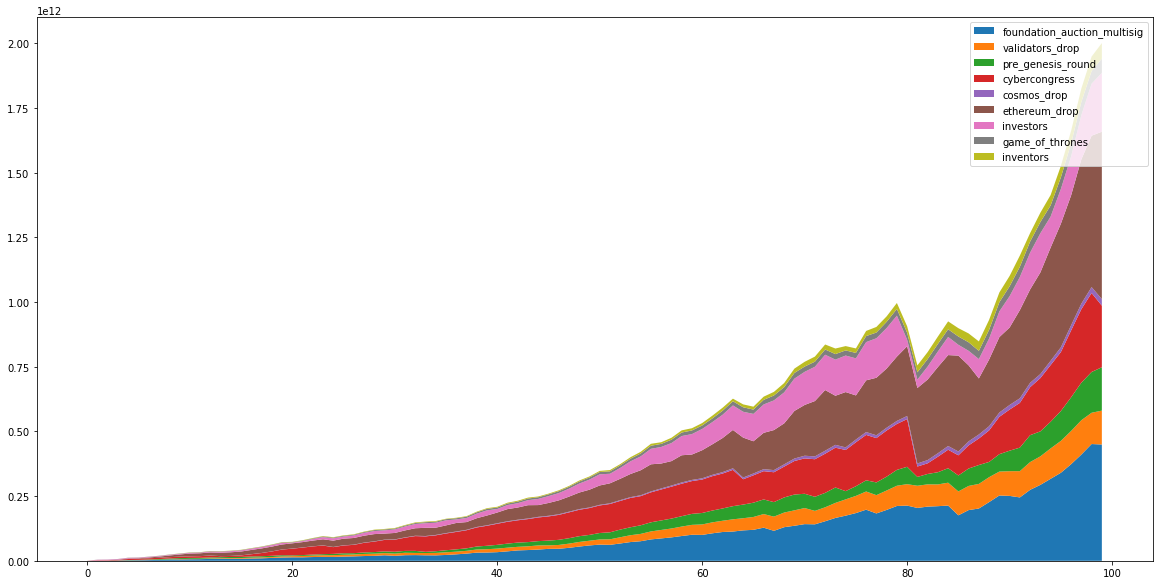

In [881]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
y = np.array([
    [stat[group] for stat in all_stats]
    for group in cyber_distribution
])

# y = y / y.sum(axis=0)
labels = [group for group in cyber_distribution]
 
plt.stackplot(x, y, labels=labels)
plt.legend()
plt.show()

### Tokens unclaimed

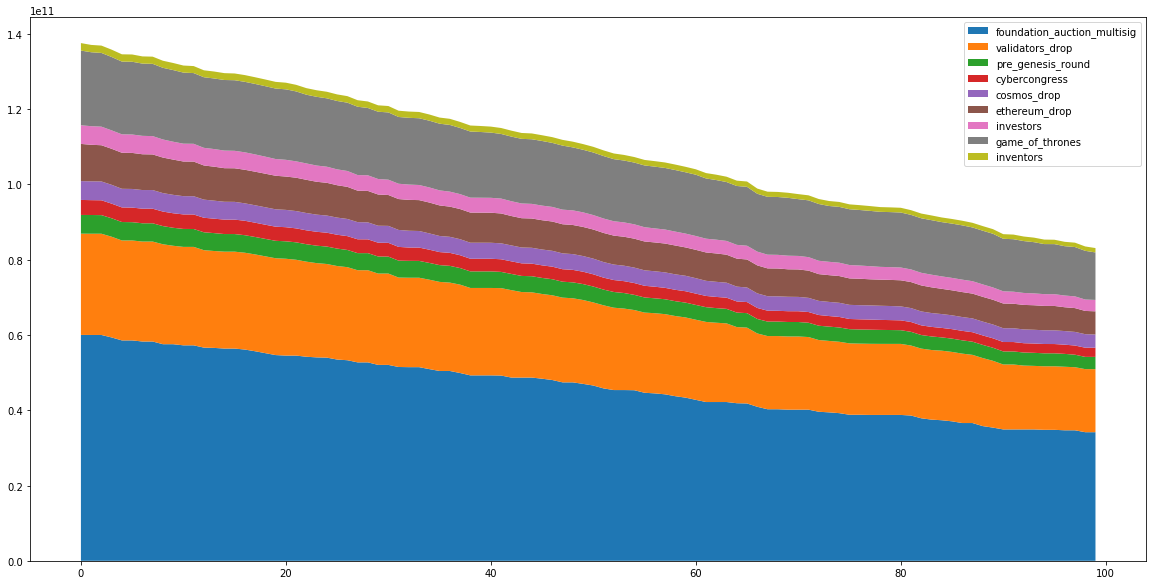

In [882]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
y = [
    [stat["unclaimed_" + group] for stat in all_stats]
    for group in cyber_distribution
]
labels = [group for group in cyber_distribution]
 
plt.stackplot(x, y, labels=labels)
plt.legend()
plt.show()

### Inflation and bonding

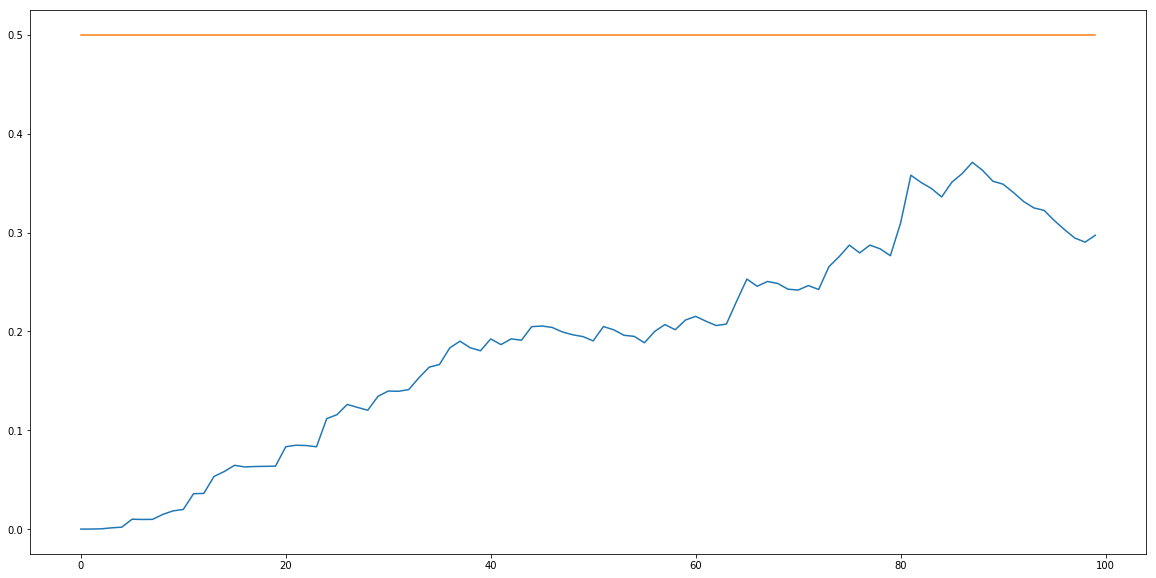

In [883]:
plt.figure(figsize=(20, 10))
x = range(len(all_stats))
bonding_rate_y = [stat["total_bonding"] / stat["total_balance"] for stat in all_stats]
inflation_y = [stat["inflation"] for stat in all_stats]

plt.plot(x, bonding_rate_y)
plt.plot(x, inflation_y)
plt.show()

- Исправить баги
    - Пометить неактуальные тесты - готово
    - Перенести тесты для быстрого метода
    - Проверить тест с валидатором - готово
    - Передавать комиссию валидатора агенту-владельцу
- Уменьшить частоту дискретизации - готово
    - Несколько выплат - аппроксимация
    - Частота пересчета - готово
- Добавить новых агентов на каждой итерации (каждый интервал сеть растет в N раз)
- Добавить быструю реализацию обмена - готово

# Инфляция не меняется!!!!!!!!!!!!!
# Новые агенты не получают транзакции
# Claimed и unclaimed не совпадают

- Увеличить скорость работы через использование numpy
- Начальный агент, который раздает генезис транзакции

- Параметр роста за итерацию + новая когорта
- Дискретизация